<table>
<tr>
    <td width=15%>
        <img src="logo-uca-site.png" width="100%"/>
    </td>
    <td width=75%>
        <center>
            <h1>Projet Analyse de Survie</h1>
            <h2>Problématique : Durée avant d'acception à l'embauche</h2>
        </center>
    </td>
    <td width=15%>
        <a href="theo.jean2@etu.uca.fr" style="font-size: 16px; font-weight: bold">UCA UFR Mathématiques</a><br/>
        Théo JEAN Florentin ROUX<br/>
    </td>
</tr>
</table>

<hr>


https://www.kaggle.com/datasets/avikumart/hrdatasetclassif/data

# Table des matières <a class="anchor" id="up"></a>

* [1. Caractéristiques des données](#chapter1)
    * [1.1. Description des données](#section_1_1)
    * [1.2. Analyse exploratoire](#section_1_2)
* [2. Analyse de survie](#chapter2)
    * [2.1. Définition des variables d'intérêt](#section_2_1)
    * [2.2. Estimation des fonctions](#section_2_2)
        * [2.2.1. Estimateur de la fonction de survie S(t) : Kaplan-Meier ](#section_2_2_1) 
        * [2.2.2. Estimateur de la fonction de risque cumulatif H(t) : Nelson Aalen](#section_2_2_2)
        * [2.2.3. Densité de risque instantané h(t)](#section_2_2_3)
        * [2.2.4. Estimateur de Breslow](#section_2_2_4)
        * [2.2.5. Log Rank](#section_2_2_5)
        * [2.2.6. Cox Proportional Hazard Model](#section_2_2_6)
    * [2.3. Estimation paramétrique](#section_2_3)
        * [2.3.1. AFT sans covariables](#section_2_3_1)
        * [2.3.2. AFT avec covariables](#section_2_3_2)
    * [2.4. Machine Learning](#section_2_4)
        * [2.4.1. Modèles classiques](#section_2_4_1)
        * [2.4.2. SVM avec scikit-learn survival](#section_2_4_2)

# 1. Caractéristiques des données : <a class="anchor" id="chapter1"></a>

In [1]:
from skimpy import skim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from scipy.stats import kstest
import scipy

## 1.1 Description des données: <a class="anchor" id="section_1_1"></a>

- Candidate - Numéro de référence unique pour identifier le candidat
- DOJ Extended - Date d'entrée en fonction demandée par le candidat ou non
- Duration to accept offer - Nombre de jours pris par le candidat pour accepter l'offre
- Notice period - Délai de préavis avant que le candidat ne puisse rejoindre l'entreprise
- Offered band - Une fourchette est proposée au candidat en fonction de son expérience et de ses performances.
- Pecent hike expected in CTC - Pourcentage d'augmentation attendu par le candidat
- Percent hike offered in CTC - Pourcentage d'augmentation offert par l'entreprise
- Percent difference CTC - Différence entre l'augmentation attendue et offerte
- Joining Bonus - Prime d'adhésion accordée ou non
- Candidate relocate actual - Les candidats doivent déménager ou non
- Gender - Sexe
- Candidate Source - Source d'obtention du curriculum vitae du candidat
- Rex in Yrs - Années d'expérience pertinentes
- LOB - Secteur d'activité pour laquelle l'offre a été déployée
- Location - Localisation de l'entreprise pour laquelle l'offre a été déployée
- Age - Age
- Status - Variable cible selon que le candidat a adhéré ou non

In [2]:
df = pd.read_csv('Data/hr_data.csv')

# Transformation de la varible "Status" en version binaire :
df['Status'] = np.where(df['Status'] == 'Joined', 1, 0)
df['Gender'] = np.where(df['Gender'] == 'Female', 1, 0)

skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 8995   │ │ int64       │ 8     │                                                          │
│ │ Number of columns │ 18     │ │ string      │ 7     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 3     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name      ┃ NA ┃ NA % ┃ mean    ┃ sd     ┃ p0      ┃ p25     ┃ p50     ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ SLNO             │  0 │    0 │    6000 │   3400 │       1 │    3200 │    6000 │    8700 │   12000 │ ▇▇▇▇▇▅ │  │
│ │ Candidate Ref    │  0 │    0 │ 2800000 │ 490000 │ 2100000 │ 2400000 │ 2800000 │ 3300000 │ 3800000 │ ▇▇▃▃▇▂ │  │
│ │ Duration to      │  0 │    0 │      21 │     26 │       0 │       3 │      10 │      33 │     220 │   ▇▂   │  │
│ │ accept offer     │    │      │         │        │         │         │         │         │         │        │  │
│ │ Notice period    │  0 │    0 │      39 │     22 │       0 │      30 │      30 │      60 │     120 │ ▁▇▁▃▁  │  │
│ │ Pecent hike      │  0 │    0 │      44 │     30 │     -69 │      27 │      40 │      54 │     360 │   ▇▁   │  │
│ │ expected in CTC  │    │      │         │        │         │         │         │         │         │        │  │
│ │ Percent hike     │  0 │    0 │      41 │     36 │     -61 │      22 │      36 │      50 │     470 │   ▅▇   │  │
│ │ offered in CTC   │    │      │         │        │         │         │         │         │         │        │  │
│ │ Percent          │  0 │    0 │    -1.6 │     20 │     -67 │    -8.3 │       0 │       0 │     300 │   ▅▇   │  │
│ │ difference CTC   │    │      │         │        │         │         │         │         │         │        │  │
│ │ Gender           │  0 │    0 │    0.17 │   0.38 │       0 │       0 │       0 │       0 │       1 │ ▇    ▂ │  │
│ │ Rex in Yrs       │  0 │    0 │     4.2 │    2.5 │       0 │       3 │       4 │       6 │      24 │  ▇▇▂   │  │
│ │ Age              │  0 │    0 │      30 │    4.1 │      20 │      27 │      29 │      34 │      60 │  ▅▇▅   │  │
│ │ Status           │  0 │    0 │    0.81 │   0.39 │       0 │       1 │       1 │       1 │       1 │ ▂    ▇ │  │
│ └──────────────────┴────┴──────┴─────────┴────────┴─────────┴─────────┴─────────┴─────────┴─────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                           ┃ NA    ┃ NA %      ┃ words per row            ┃ total words         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ DOJ Extended                          │     0 │         0 │                        1 │                8995 │  │
│ │ Offered band                          │     0 │     

In [3]:
df.head(5)

,SLNO,Candidate Ref,DOJ Extended,Duration to accept offer,Notice period,Offered band,Pecent hike expected in CTC,Percent hike offered in CTC,Percent difference CTC,Joining Bonus,Candidate relocate actual,Gender,Candidate Source,Rex in Yrs,LOB,Location,Age,Status
0,1,2110407,Yes,14,30,E2,-20.79,13.16,42.86,No,No,1,Agency,7,ERS,Noida,34,1
1,2,2112635,No,18,30,E2,50.00,320.00,180.00,No,No,0,Employee Referral,8,INFRA,Chennai,34,1
2,3,2112838,No,3,45,E2,42.84,42.84,0.00,No,No,0,Agency,4,INFRA,Noida,27,1
3,4,2115021,No,26,30,E2,42.84,42.84,0.00,No,No,0,Employee Referral,4,INFRA,Noida,34,1
4,5,2115125,Yes,1,120,E2,42.59,42.59,0.00,No,Yes,0,Employee Referral,6,INFRA,Noida,34,1


In [4]:
len(df[(df["Status"] == 0) & (df["Duration to accept offer"] > 60)]) # Nombre de candidats dont le délais de réponse
# est supérieur à 2 mois

239

In [5]:
df.describe()

,SLNO,Candidate Ref,Duration to accept offer,Notice period,Pecent hike expected in CTC,Percent hike offered in CTC,Percent difference CTC,Gender,Rex in Yrs,Age,Status
count,8995.000000,8.995000e+03,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000
mean,5970.984325,2.843647e+06,21.434464,39.291829,43.864804,40.657356,-1.573802,0.172429,4.239022,29.913174,0.813007
std,3373.963454,4.863448e+05,25.811616,22.220239,29.788975,36.064060,19.610729,0.377774,2.547571,4.097912,0.389927
min,1.000000,2.109586e+06,0.000000,0.000000,-68.830000,-60.530000,-67.270000,0.000000,0.000000,20.000000,0.000000
25%,3207.500000,2.386476e+06,3.000000,30.000000,27.270000,22.090000,-8.330000,0.000000,3.000000,27.000000,1.000000
50%,5976.000000,2.807482e+06,10.000000,30.000000,40.000000,36.000000,0.000000,0.000000,4.000000,29.000000,1.000000
75%,8739.000000,3.300060e+06,33.000000,60.000000,53.850000,50.000000,0.000000,0.000000,6.000000,34.000000,1.000000
max,12333.000000,3.836076e+06,224.000000,120.000000,359.770000,471.430000,300.000000,1.000000,24.000000,60.000000,1.000000


## 1.2. Analyse exploratoire : <a class="anchor" id="section_1_2"></a>
[Up](#up)

On va d'abord s'intéresser à la variable de survie : **Duration to accept offer** 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

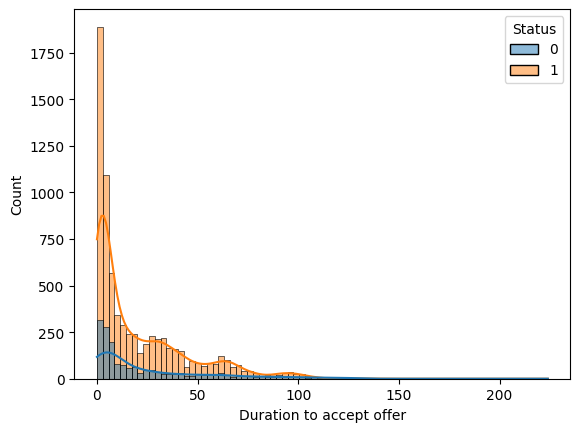

In [6]:
sns.histplot(data=df, x="Duration to accept offer", kde=True, hue='Status')
plt.show()

On va chercher a déterminer sa loi :

In [7]:
noms_lois = ['norm', 'beta','gamma', 't', 'lognorm', 'invgamma', 'invgauss',  'loggamma', 'alpha','chi2', 'f', 'expon']

def test_lois(data):
    sse_thr = 0.10
    y, x = np.histogram(data,density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    sse = np.inf
    for name in noms_lois:
        dist = getattr(scipy.stats, name)
        param = dist.fit(data)

        loc = param[-2]
        scale = param[-1]
        arg = param[:-2]

        pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
        model_sse = np.sum((y - pdf)**2)

        # Si le SSE est diminué, enregistrer la loi
        if model_sse < sse :
            best_pdf = pdf
            sse = model_sse
            best_loc = loc
            best_scale = scale
            best_arg = arg
            best_name = name
    return(x, y, best_pdf, best_name, best_loc, best_scale, best_arg, sse)

# pdf = Probability density function

In [8]:
x, y, best_pdf ,best_name, best_loc, best_scale, best_arg, sse = test_lois(df['Duration to accept offer'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in scalar multiply
  Lhat = muhat - Shat*mu


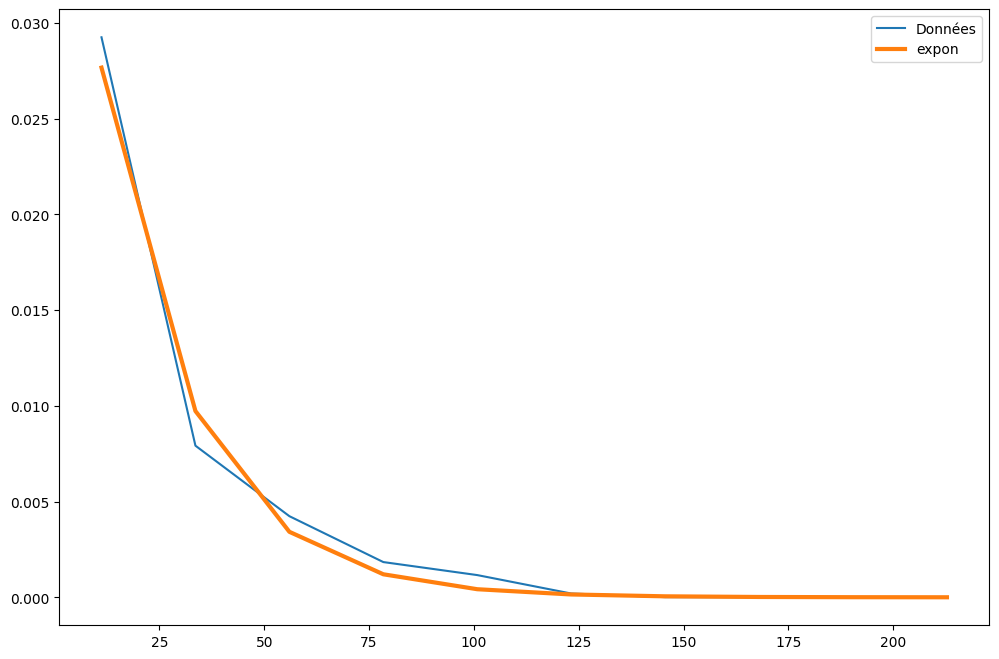

Selected Model :  expon
Loc. param. :  0.0
Scale param. :  21.434463590883823
Other arguments :  ()
SSE :  7.408864085906509e-06


In [9]:
plt.figure(figsize=(12,8))
plt.plot(x, y, label="Données")
plt.plot(x, best_pdf, label=best_name, linewidth=3)
plt.legend(loc='upper right')
plt.show()

# Détails sur la loi sélectionnée
print("Selected Model : ", best_name)
print("Loc. param. : ", best_loc)
print("Scale param. : ", best_scale)
print("Other arguments : ", best_arg)
print("SSE : ", sse)


La variable semble suivre une loi **exponentielle**


Maintenant pour notre variable de censure : **Status**

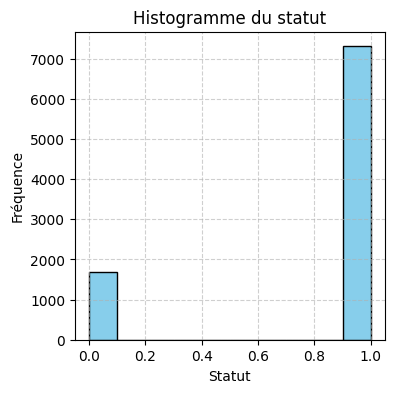

In [10]:
plt.figure(figsize=(4, 4))  
plt.hist(df["Status"], color='skyblue', edgecolor='black')
plt.xlabel("Statut")
plt.ylabel("Fréquence")
plt.title("Histogramme du statut")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Enfin, on va regarder rapidement les distributions des covariables :

In [11]:
# catégorisation des colonnes quali et quanti :

num_col = [col for col in df.columns if df[col].dtypes in ['int64','float64']]
cat_col = [col for col in df.columns if df[col].dtypes == 'object']

print("Colonnes quanti: \n",num_col)
print('Colonnes quali: \n',cat_col)

Colonnes quanti: 
 ['SLNO', 'Candidate Ref', 'Duration to accept offer', 'Notice period', 'Pecent hike expected in CTC', 'Percent hike offered in CTC', 'Percent difference CTC', 'Gender', 'Rex in Yrs', 'Age', 'Status']
Colonnes quali: 
 ['DOJ Extended', 'Offered band', 'Joining Bonus', 'Candidate relocate actual', 'Candidate Source', 'LOB', 'Location']


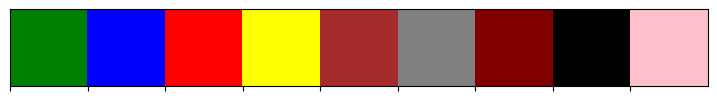

In [12]:
color = ["green", "Blue", "Red", "Yellow", "Brown", "Grey",'Maroon','black','Pink']
sns.set_palette(color)
sns.palplot(sns.color_palette())

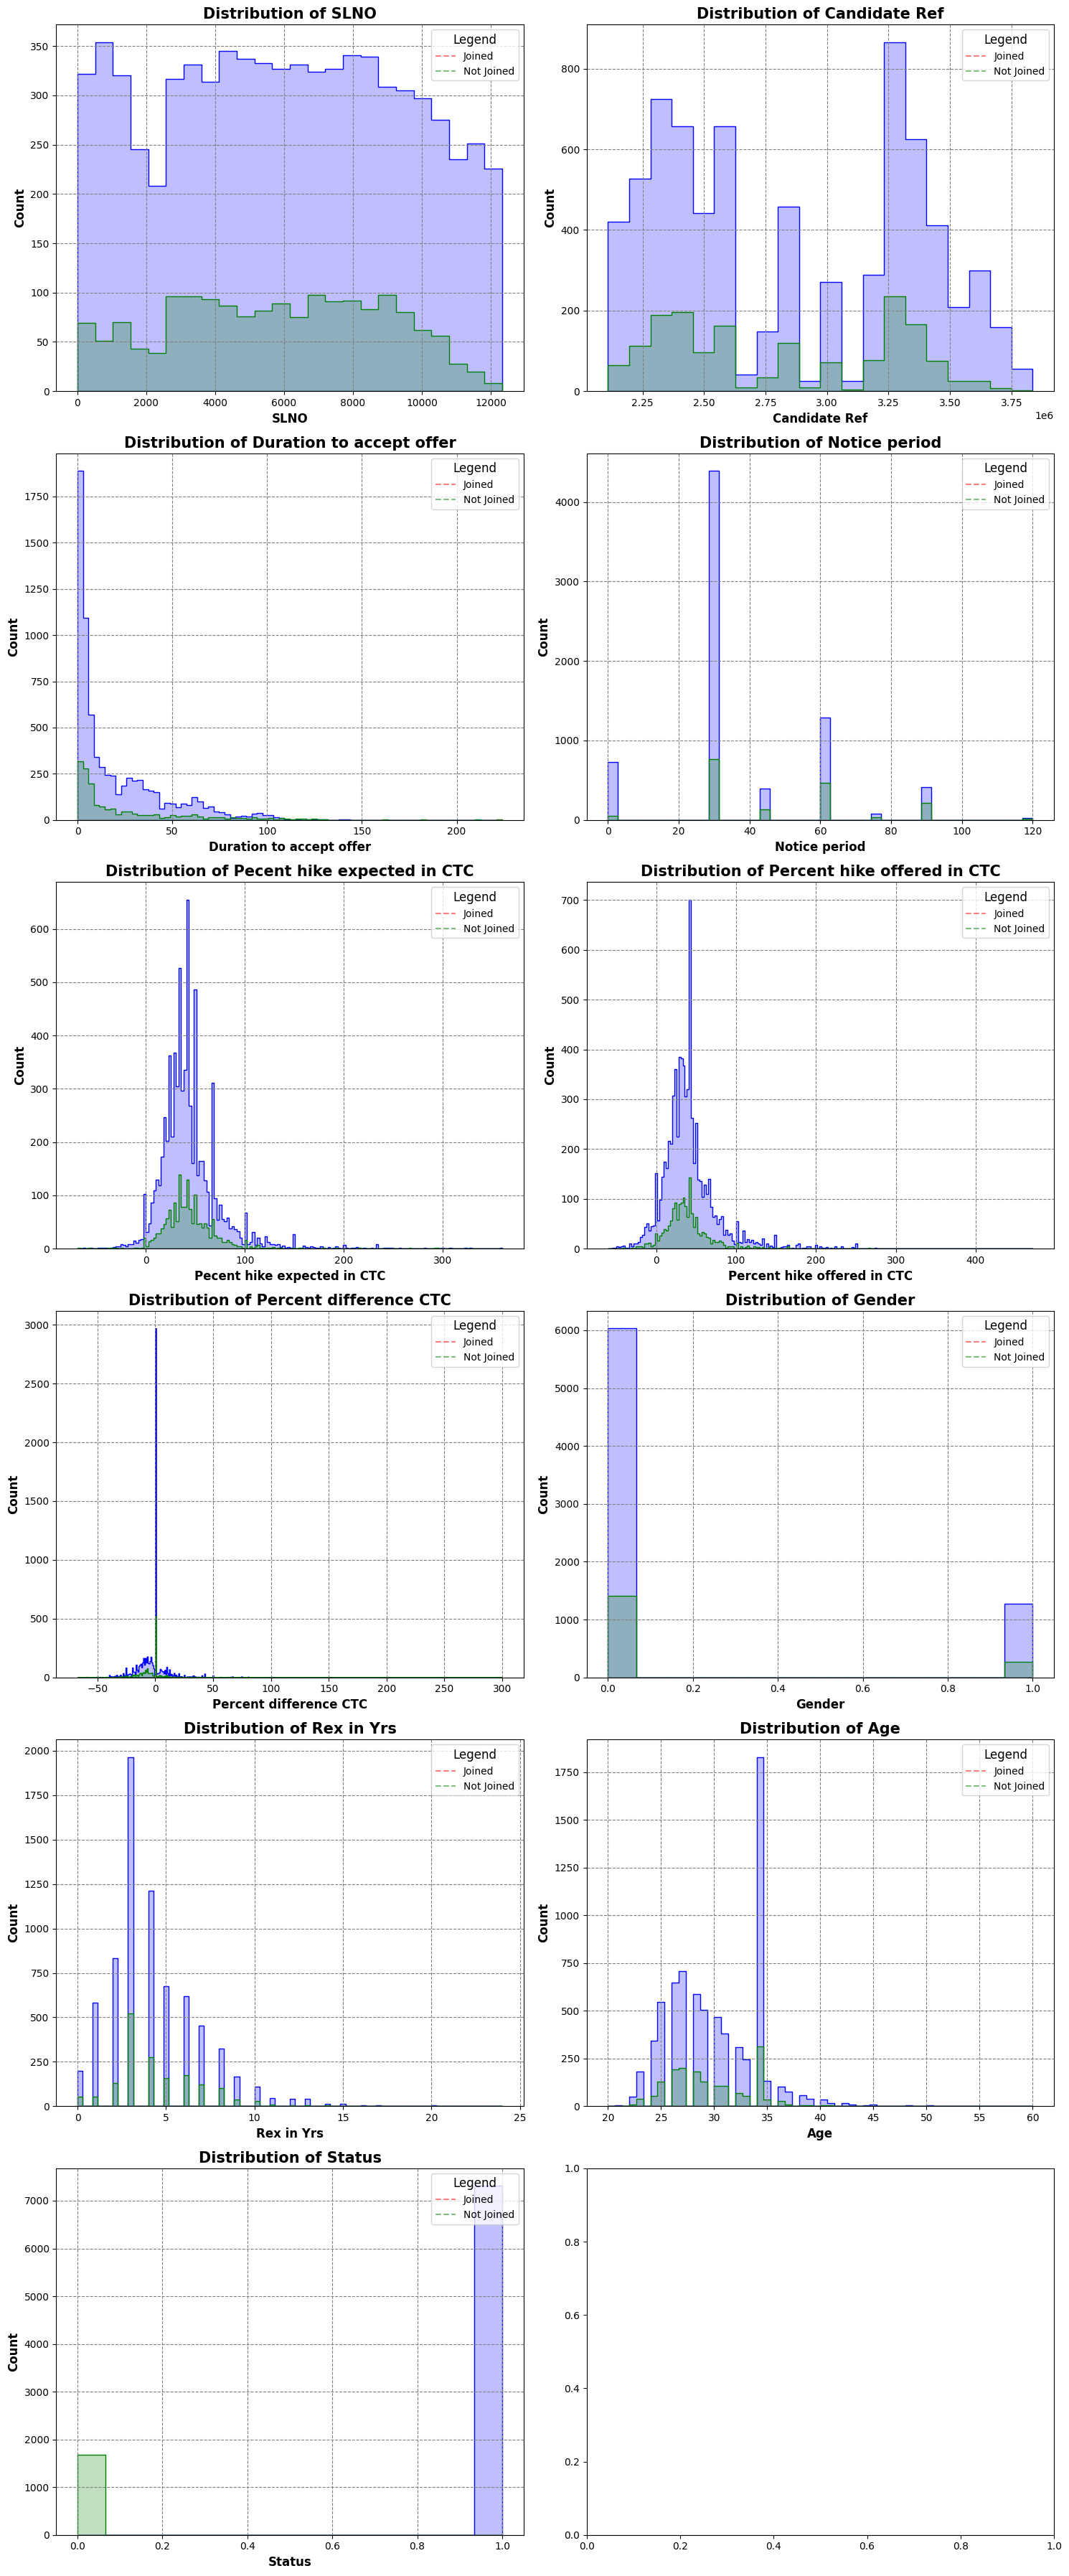

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')
    
    num_cols_per_row = 2

    # Calculer le nombre total de lignes nécessaires
    num_rows = math.ceil(len(num_col) / num_cols_per_row)
    fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(15, 6 * num_rows))

    axes = axes.flatten()

    for i, col in enumerate(num_col):
        ax = axes[i]

        ax.axvline(x=df[df['Status'] == 'joined'][col].mean(), linestyle='--', alpha=0.5, color='red', label='Joined')
        ax.axvline(x=df[df['Status'] == 'not joined'][col].mean(), linestyle='--', alpha=0.5, color='green', label='Not Joined')

        sns.histplot(data=df, x=col, hue='Status', element='step', common_norm=False, ax=ax)

        ax.set_title(f'Distribution of {col}', weight='bold', size=15)
        ax.set_xlabel(col, size=12, weight='bold')
        ax.set_ylabel('Count', size=12, weight='bold')

        ax.legend(loc='best', frameon=True, title='Legend', title_fontsize='12')

        ax.grid(visible=True, linestyle='--', color='gray')

    plt.tight_layout()

    plt.show()


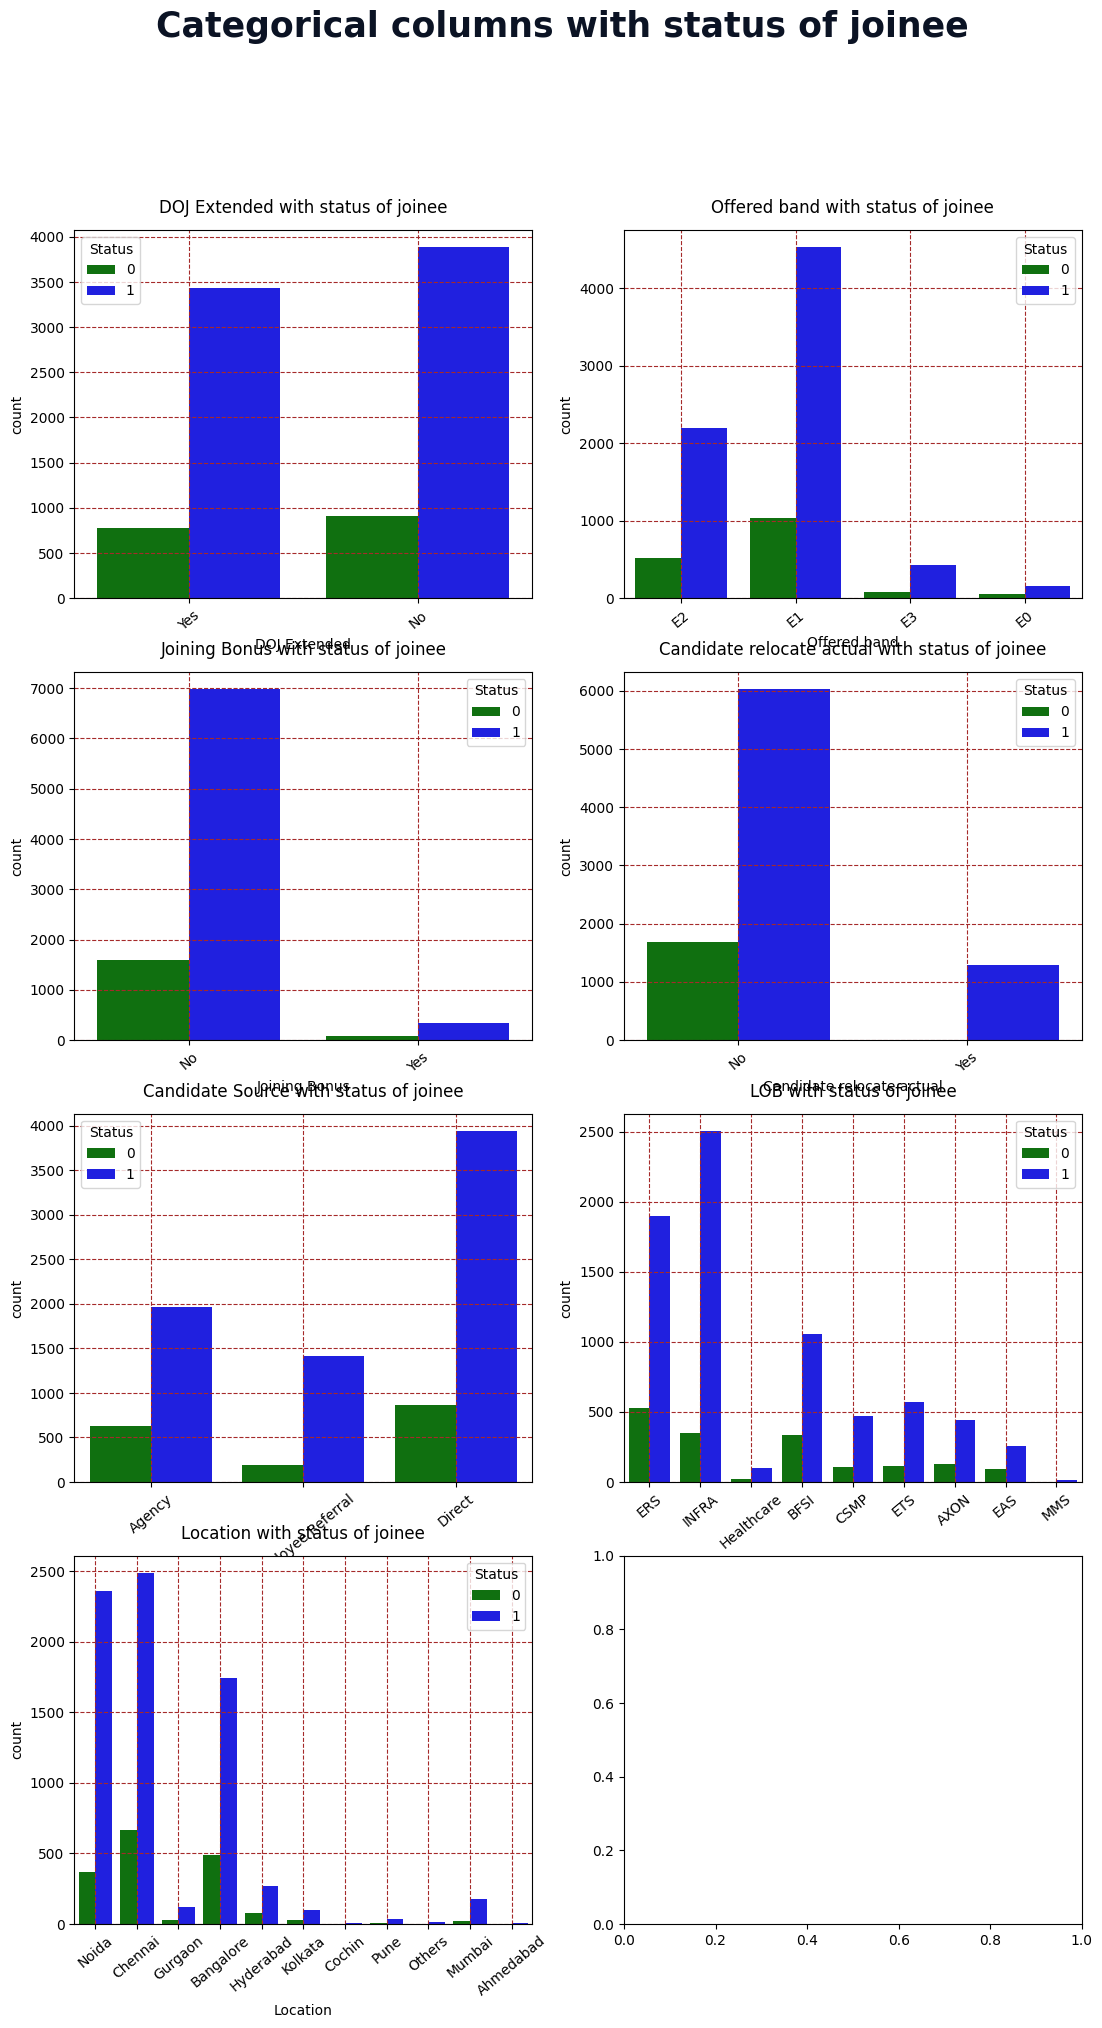

In [14]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')

    # Variables quanti
    col_list = [col for col in cat_col if col != 'Status']

    fig, ax = plt.subplots(4, 2, figsize=(13, 22))
    for idx, col in enumerate(col_list):
        sns.countplot(x=col, hue='Status', data=df, ax=ax[idx // 2, idx % 2])
        ax[idx // 2, idx % 2].grid(visible=True, linestyle='--', color='brown')
        ax[idx // 2, idx % 2].set_xticklabels(list(df[col].unique()), rotation=40)
        ax[idx // 2, idx % 2].set_title(f'{col} with status of joinee', pad=12)

    plt.suptitle(f'Categorical columns with status of joinee', fontsize=25, fontweight='bold', color='#0b1324')
    plt.show()

In [15]:
df["LOB"].unique()

array(['ERS', 'INFRA', 'Healthcare', 'BFSI', 'CSMP', 'ETS', 'AXON', 'EAS',
       'MMS'], dtype=object)

- ERS - Engineering and Research Services : Activités liées à la conception, au développement et à la recherche.
- INFRA : Activités liées à l'infrastructure informatique, aux réseaux, aux serveurs, etc.
- Healthcare : Activités en lien avec la santé.
- BFSI - Banking, Financial Services, and Insurance : Secteur bancaire, services financiers et assurance. 
- CSMP - Customer Service and Management Platform : Activités liées à la gestion de la relation client.
- ETS - Engineering and Technical Services : Similaire à ERS, se concentrant sur les services techniques et d'ingénierie.
- AXON - ? Peut-être particulier à l'entreprise
- EAS - Enterprise Application Services : Activités de développement, gestion et maintenance d'applications logicielles.
- MMS - Manufacturing and Management Services : Activités liées à la fabrication et à la gestion, notamment dans l'industrie manufacturière.

# 2. Analyse de survie <a class="anchor" id="chapter2"></a>
[Up](#up)

## 2.1. Définition des variables d'intérêt : <a class="anchor" id="section_2_1"></a>

La variable de temps $T$ : "Duration to accept offer" => Mesure le temps écoulé avant d’avoir subit l’événement d’intérêt ("Status"), ici avant l'acceptation du candidat à l'offre. 

- $\textbf{Fonction de survie}$ $S(t)$ (estimateur naturel sans censure): $$S(t) = P(T > t) = \frac{1}{n} \sum_{i=1}^{n} \mathbb{I}(t_i > t)$$ 

est une fonction qui décrit la probabilité qu'un candidat accepte l'offre après une durée supérieure à t.

- $\textbf{La densité de risque instantanné}$, notée $h(t)$, est définie comme la probabilité que l'événement survienne à un instant précis sachant que l'individu a survécu jusqu'à $t$. Ici, que le candidat ne rejoigne pas l'entreprise à l'instant $t$ sachant qu'il avait accepté jusqu'ici.
$$h(t) = H'(t) = -\frac{S'(t)}{S(t)}$$

- $\textbf{La fonction de risque}$, notée $H(t)$, représente le taux cumulé d’individus qui augmente avec le temps.

$$ H(t) = \int_{0}^{t} h(u) \, \mathrm{d}u \$$

### Données censurées :

Il y a censure dans un jeu de données en analyse de survie lorsque l'information sur le temps de survie d'un individu n'est pas complète :

- Censure à gauche : La censure à gauche se produit lorsque l'observation d'un individu commence après le début de l'étude ou après un moment spécifique, ce qui signifie que nous n'avons pas d'information sur la période de temps antérieure à cette date.
- Censure à droite :  Elle se produit lorsque l'on suit les individus pendant une période de temps, mais que l'événement d'intérêt ne se produit pas pour certains individus avant la fin de la période d'observation.

Pour nous, les données sont censurées (à droite) lorsque le candidat ne rejoint pas l'entreprise, c'est-à-dire lorsque la variable `Status` est égale à 0.

## 2.2. Estimation des fonctions : <a class="anchor" id="section_2_2"></a>
[Up](#up)

<center>

|                | Kaplan-Meier                                       | Nelson-Aalen                               | Breslow                                   |Cox
|----------------|---------------------------------------------------|--------------------------------------------|--------------------------------------------|------------------------------------------|
| Avec censure   | $1 - \prod_{i=1}^{n}\left(1 - \frac{d_i}{n_i}\right)$ | $\sum_{i=1}^{n}\frac{d_i}{n_i}$            | $\sum_{t_i \leq t} \frac{d_i}{n_i} \left(\frac{1}{n_i} + \frac{1}{n_{i-1}}\right)$ |$ h(t) = h_0(t) \cdot \exp(\beta_1x_1 + \beta_2x_2 + ... + \beta_kx_k) $
| Sans censure   | $S(t)=[S(t-1)]\cdot\left(1-\frac{d}{n}\right)$ | $\sum_{i=1}^{n}\frac{d_i}{n_i}$            | $\sum_{t_i \leq t} \sum_{j \leq t_i} \frac{d_{ij}}{n_{ij}} \left(\frac{1}{n_{ij}} + \frac{1}{n_{ij-1}}\right)$ |$S(t)=[S(t-1)]\cdot\left(1-\frac{d}{n}\right)$

<center>

### 2.2.1. Estimateur de la fonction de survie S(t) : `Kaplan-Meier` <a class="anchor" id="section_2_2_1"></a>

#### Théorie : 
Dans cette première partie, nous utilisons l'estimateur de Kaplan-Meier pour estimer la fonction de survie S(t). Le graphique obtenu nous montre comment la probabilité de survie évolue au fil du temps pour notre groupe de données.

- Formule avec censure : $$ S_{KM}(t) = \prod_{i: t_i \leq t} \left(1 - \frac{d_i}{n_i}\right) $$
- Formule sans censure : $$S(t)=[S(t-1)]\cdot\left(1-\frac{d}{n}\right)$$


In [16]:
df_non_cens = df[df['Status'] == 1]

Médiane (censure): 15.0
Intervalle de confiance à 95% (censure):
       KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0                  0.918057                0.929035
1.0                  0.834157                0.849276
2.0                  0.779393                0.796377
3.0                  0.727651                0.746020
4.0                  0.685739                0.705004
...                       ...                     ...
143.0                0.002995                0.013839
163.0                0.002995                0.013839
181.0                0.002995                0.013839
210.0                0.002995                0.013839
224.0                0.002995                0.013839

[136 rows x 2 columns]
Médiane (sans censure): 10.0
Intervalle de confiance à 95% (sans censure):
       KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0                  0.899282                0.912656
1.0                  0.797129                0.815245
2.0                  0.731

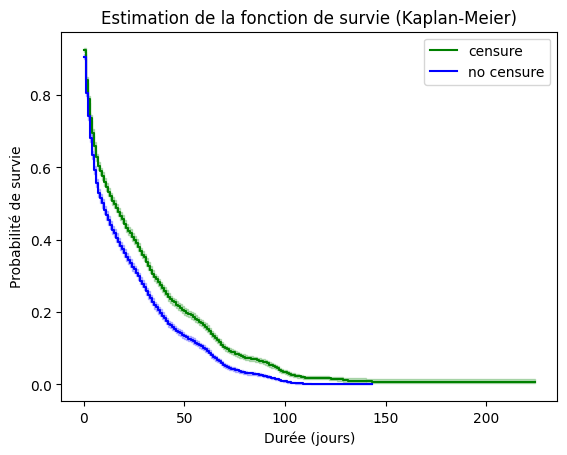

In [17]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Créez un objet KaplanMeierFitter pour les données avec censure
kmf = KaplanMeierFitter()
kmf.fit(df['Duration to accept offer'], event_observed=df['Status'])

# Créez un objet KaplanMeierFitter pour les données sans censure
kmf_no_cens = KaplanMeierFitter()
kmf_no_cens.fit(df_non_cens['Duration to accept offer'], event_observed=df_non_cens['Status'])

median_censure = kmf.median_survival_time_
ci_censure = kmf.confidence_interval_
median_no_cens = kmf_no_cens.median_survival_time_
ci_no_cens = kmf_no_cens.confidence_interval_

print("Médiane (censure):", median_censure)
print("Intervalle de confiance à 95% (censure):")
print(ci_censure)

print("Médiane (sans censure):", median_no_cens)
print("Intervalle de confiance à 95% (sans censure):")
print(ci_no_cens)

kmf.plot(label='censure', ci_show=True)

kmf_no_cens.plot(label='no censure', ci_show=True)

plt.xlabel('Durée (jours)')
plt.ylabel('Probabilité de survie')
plt.title('Estimation de la fonction de survie (Kaplan-Meier)')
plt.legend()

plt.show()


Nous avons donc aussi la possibilité de modéliser la fonction de survie par rapport aux covariables, comme ici en fonction de la variable "LOB" correspondant au secteur d'activité de l'offre :

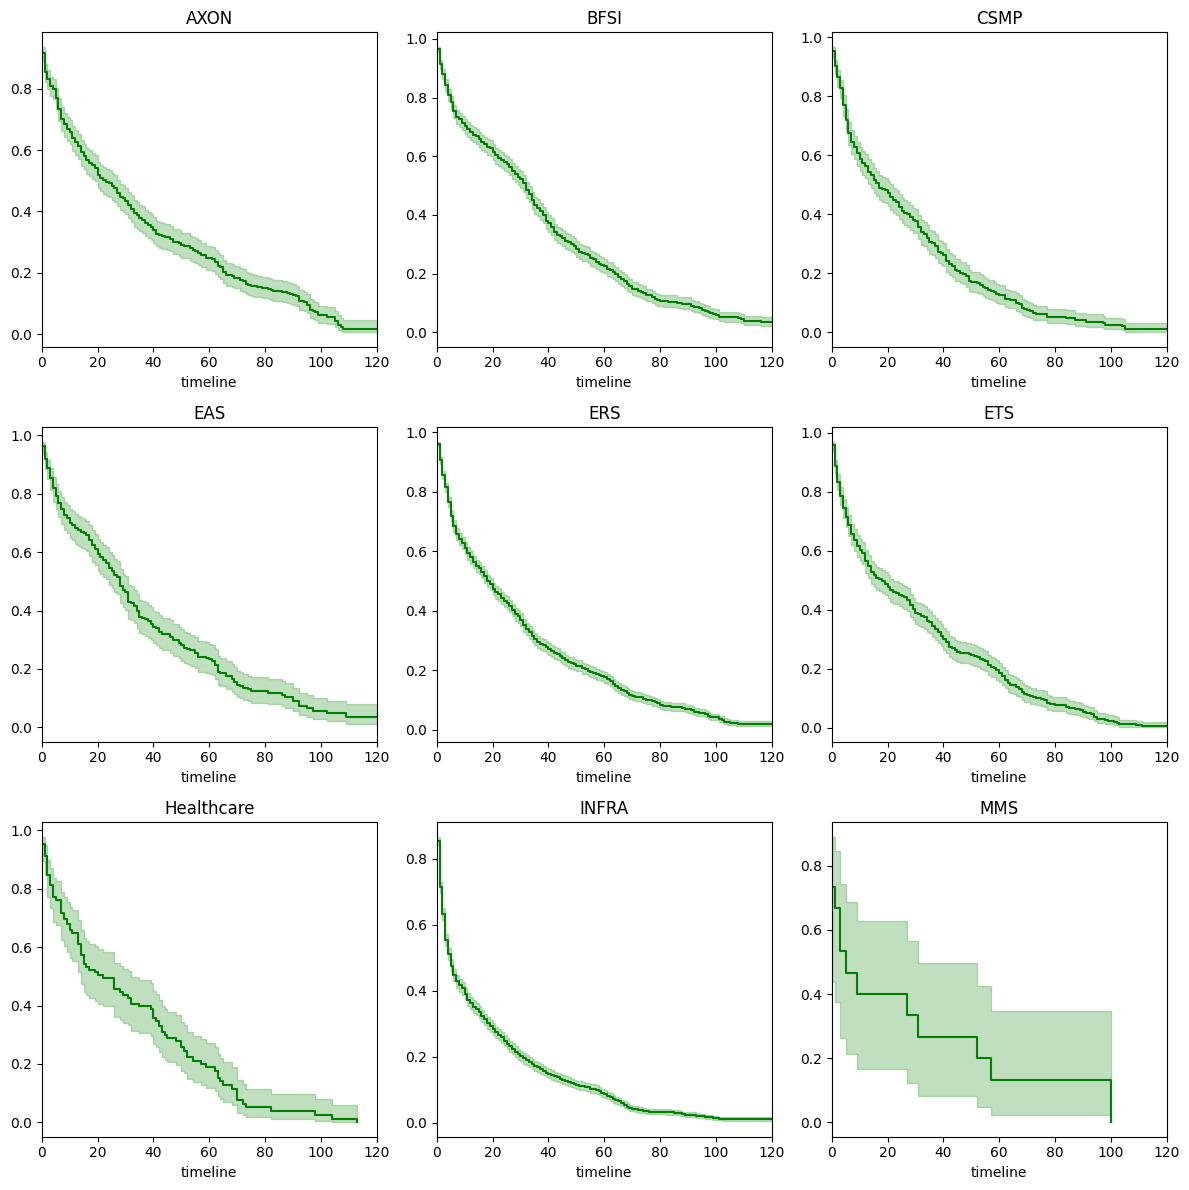

In [18]:
plt.figure(figsize=(12,12))
job = df.sort_values(by = ['LOB'])["LOB"].unique()
for i, job in enumerate(job):
  ax = plt.subplot(3, 3, i + 1)
  ix = df['LOB'] == job
  kmf.fit(df["Duration to accept offer"][ix], df["Status"][ix], label = job)
  kmf.plot_survival_function(ax = ax, legend = False)
  plt.title(job)
  plt.xlim(0, 120)
plt.tight_layout()

### Biais
L'estimateur de Kaplan-Meier est biaisé, mais asymptotiquement sans biais.

In [19]:
# censure
t = 30  # Par exemple, 30 jours
observed_survival = kmf.survival_function_at_times(t)
expected_survival = (1 - df[df['Duration to accept offer'] <= t]['Status'].mean())
bias = observed_survival - expected_survival
bias

30    0.149026
Name: MMS, dtype: float64

In [20]:
# no censure
t = 30  # Par exemple, 30 jours
observed_survival = kmf_no_cens.survival_function_at_times(t)
expected_survival = (1 - df_non_cens[df_non_cens['Duration to accept offer'] <= t]['Status'].mean())
bias = observed_survival - expected_survival
bias

30    0.270751
Name: KM_estimate, dtype: float64

Le biais est une mesure de l'écart entre l'estimation de Kaplan-Meier et la vraie fonction de survie. Il indique si l'estimateur surestime ou sous-estime la probabilité de survie à un moment donné. Ici, le biais est positif, cela signifie que l'estimateur de Kaplan-Meier est enclin à surestimer la probabilité de survie par rapport à la réalité.

#### Variance
La variance de l'estimateur de Kaplan-Meier peut être calculée de la manière suivante :


In [21]:
# censure
variance = (kmf.survival_function_ - kmf.survival_function_**2).sum()
variance

MMS    1.848889
dtype: float64

In [22]:
# no censure
variance = (kmf_no_cens.survival_function_ - kmf_no_cens.survival_function_**2).sum()
variance

KM_estimate    12.414094
dtype: float64

### 2.2.2. Estimateur de la fonction de risque cumulatif H(t) : `Nelson-Aalen` <a class="anchor" id="section_2_2_2"></a>
[Up](#up)

#### Théorie :

H(t) est définie comme la somme cumulative des risques au fil du temps. Elle est souvent utilisée lorsque les données de survie sont censurées.

- Formule avec censure : $$H(t) = \sum_{t_i \leq t} \frac{d_i}{n_i}$$ 
- Formule sans censure : $$H(t) = \sum_{i} \frac{d_i}{n_i}$$ 

où :
- $t_i$: Les instants de temps auxquels les événements surviennent.
- $d_i$: Le nombre d'événements observés à l'instant $t_i$
- $n_i$: Le nombre de sujets encore à risque  à l'instant $t_i$ 


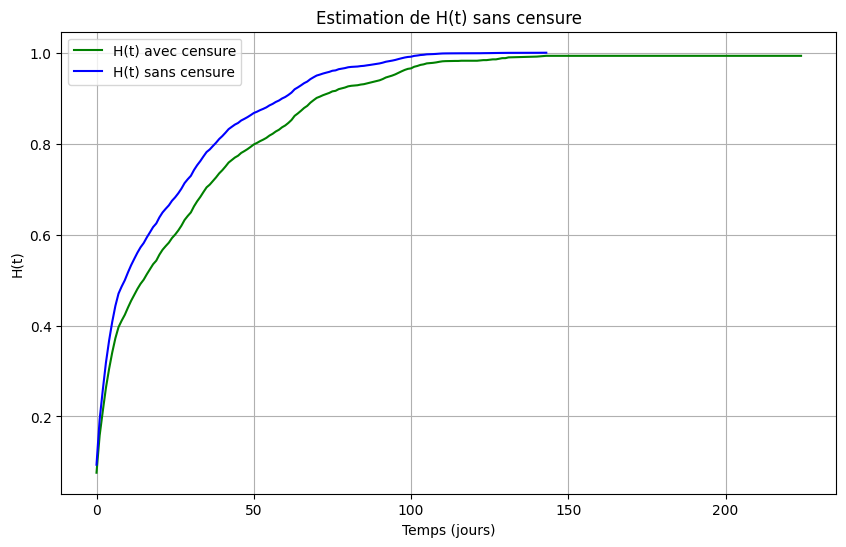

In [23]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(df['Duration to accept offer'], event_observed=df['Status'])
# Estimation de H(t) avec censure
H_t = 1 - kmf.survival_function_
# Estimation de h(t) avec censure
h_t = -H_t.diff() / kmf.survival_function_

kmf_no_cens = KaplanMeierFitter()
kmf_no_cens.fit(df_non_cens['Duration to accept offer'], event_observed=df_non_cens['Status'])
# Estimation de H(t) avec censure
H_t_no_cens = 1 - kmf_no_cens.survival_function_
# Estimation de h(t) avec censure
h_t_no_cens = -H_t_no_cens.diff() / kmf_no_cens.survival_function_

plt.figure(figsize=(10, 6))
plt.plot(H_t.index, H_t.values, label='H(t) avec censure')
plt.plot(H_t_no_cens.index, H_t_no_cens.values, label='H(t) sans censure')
plt.xlabel('Temps (jours)')
plt.ylabel('H(t)')
plt.title('Estimation de H(t) sans censure')
plt.legend()
plt.grid()
plt.show()

### 2.2.3. Densité de risque instantané h(t) : <a class="anchor" id="section_2_2_3"></a>
[Up](#up)

La densité du risque instantané h(t) est définie comme le rapport du nombre d'événements observés à un instant donné au nombre de sujets encore à risque à cet instant

- Formule sans censure : $$h(t) = \frac{d}{n}$$
- Formule avec censure : $$ h(t) = \sum_{i} \frac{d_i}{n_i} $$


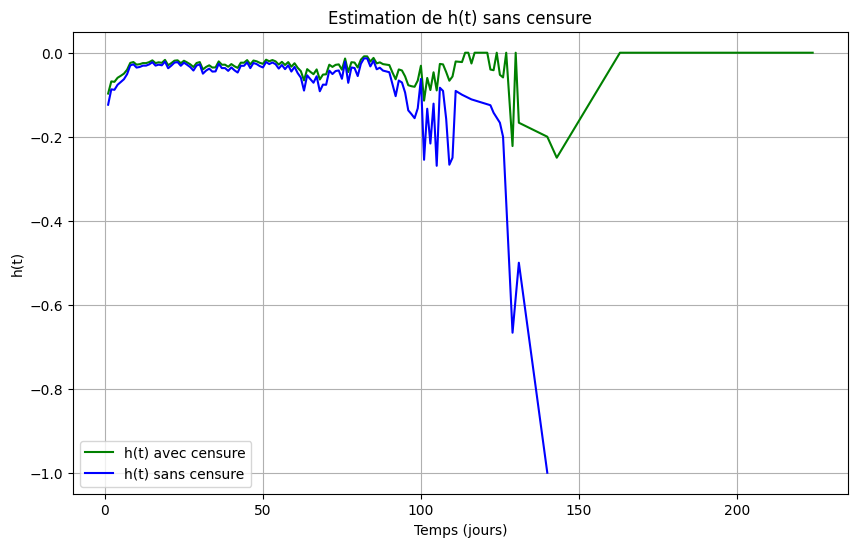

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(h_t.index, h_t.values, label='h(t) avec censure')
plt.plot(h_t_no_cens.index, h_t_no_cens.values, label='h(t) sans censure')
plt.xlabel('Temps (jours)')
plt.ylabel('h(t)')
plt.title('Estimation de h(t) sans censure')
plt.legend()
plt.grid()
plt.show()

### 2.2.4. Estimateur de `Breslow` <a class="anchor" id="section_2_2_4"></a>
[Up](#up) 

L'estimateur de Breslow est obtenu à partir de l'estimateur de Kaplan-Meier. Sa formule est la suivante :


$$\widehat{H}_{BR} = -\log(\widehat{S}_{KM})$$


où $$\widehat{S}_{KM}(t) = \prod_{i=1, t_i < t}(1 - d_iY_i)$$

L'estimateur de Breslow est utilisé pour estimer la fonction de survie dans le modèle de régression de Cox. Il permet de tenir compte de la censure dans les données de survie et fournit une estimation adaptée pour les échantillons censurés.

- Formule sans censure : $$ H(t) = \sum_{t_i \leq t} \frac{d_i}{n_i} $$
- Formule avec censure : $$ H(t) = \sum_{t_i \leq t} \sum_{j \leq t_i} \frac{d_{ij}}{n_{ij}} $$

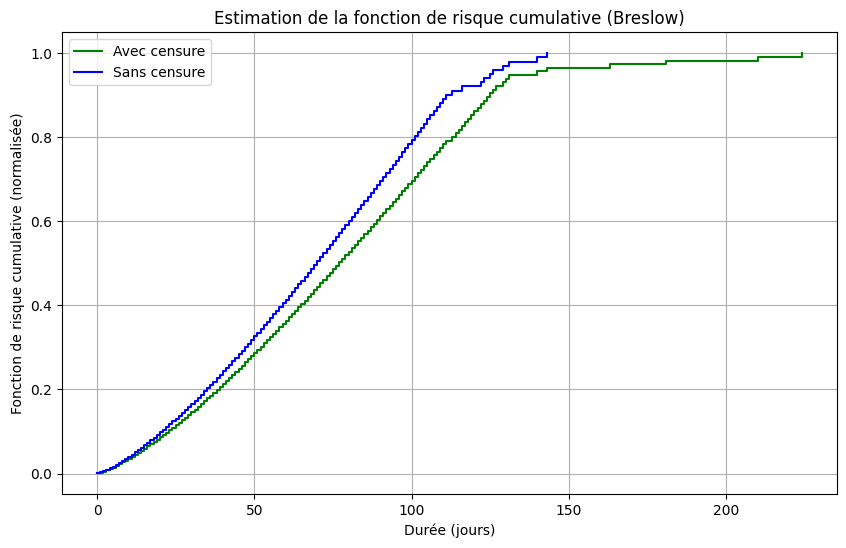

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import BreslowFlemingHarringtonFitter

bfh = BreslowFlemingHarringtonFitter()
bfh.fit(df['Duration to accept offer'], event_observed=df['Status'])

bfh_no_cens = BreslowFlemingHarringtonFitter()
bfh_no_cens.fit(df_non_cens['Duration to accept offer'], event_observed=df_non_cens['Status'])

times = np.sort(df['Duration to accept offer'].unique())

cumulative_hazard = np.zeros(len(times))
risk_sum = 0

for t in range(len(times)):
    risk_sum += np.sum(bfh.event_observed[df['Duration to accept offer'] <= times[t]])
    cumulative_hazard[t] = risk_sum

times_no_cens = np.sort(df_non_cens['Duration to accept offer'].unique())

cumulative_hazard_no_cens = np.zeros(len(times_no_cens))
risk_sum_no_cens = 0

for t in range(len(times_no_cens)):
    risk_sum_no_cens += np.sum(bfh_no_cens.event_observed[df_non_cens['Duration to accept offer'] <= times_no_cens[t]])
    cumulative_hazard_no_cens[t] = risk_sum_no_cens

cumulative_hazard = cumulative_hazard / np.max(cumulative_hazard)
cumulative_hazard_no_cens = cumulative_hazard_no_cens / np.max(cumulative_hazard_no_cens)

plt.figure(figsize=(10, 6))
plt.step(times, cumulative_hazard, where="post", label='Avec censure')
plt.step(times_no_cens, cumulative_hazard_no_cens, where="post", label='Sans censure')
plt.xlabel('Durée (jours)')
plt.ylabel('Fonction de risque cumulative (normalisée)')
plt.title('Estimation de la fonction de risque cumulative (Breslow)')
plt.legend()
plt.grid()
plt.show()


### 2.2.5. Log Rank <a class="anchor" id="section_2_2_5"></a>

Le test du log-rank compare les courbes de survie de deux groupes distincts. L'hypothèse nulle du test est que les deux groupes proviennent de la même population, c'est-à-dire qu'il n'y a pas de différence significative entre les distributions de survie des deux groupes.


Ici, nous allons comparer les distributions des courbes quand les données sont censurées vs non-censurées. Nous allons déterminer s'il y a une différence significative dans la distribution des temps de survie entre ces groupes.

Si le test du log-rank donne un résultat significatif, cela suggère que les courbes de survie sont différentes, indiquant une variation significative dans les temps de survie entre les groupes comparés. En revanche, si le test n'est pas significatif, on n'a pas suffisamment de preuves pour rejeter l'hypothèse nulle, ce qui signifie que les courbes de survie peuvent être considérées comme provenant de la même population.

In [26]:
df_uncensored = df[df["Status"] == 1]

   test_statistic             p    -log2(p)
0      230.257955  5.237054e-52  170.351505


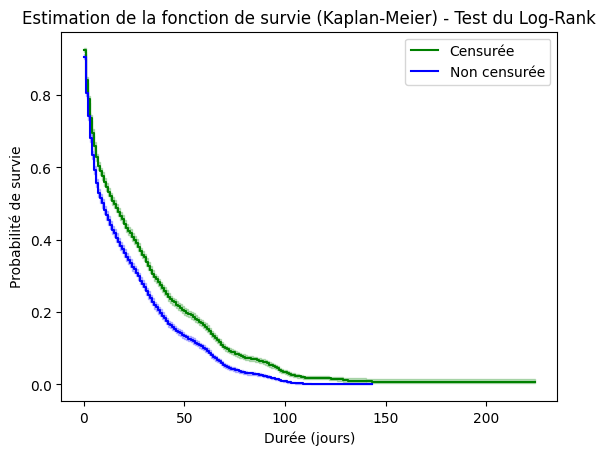

In [27]:
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf_censored = KaplanMeierFitter()
kmf_censored.fit(df['Duration to accept offer'], event_observed=df['Status'])

kmf_uncensored = KaplanMeierFitter()
kmf_uncensored.fit(df_uncensored['Duration to accept offer'], event_observed=df_uncensored['Status'])

result_logrank = logrank_test(durations_A=df['Duration to accept offer'],
                              event_observed_A=df['Status'],
                              durations_B=df_uncensored['Duration to accept offer'],
                              event_observed_B=df_uncensored['Status'])

print(result_logrank.summary)

kmf_censored.plot(label='Censurée', ci_show=True)

kmf_uncensored.plot(label='Non censurée', ci_show=True)

plt.xlabel('Durée (jours)')
plt.ylabel('Probabilité de survie')
plt.title('Estimation de la fonction de survie (Kaplan-Meier) - Test du Log-Rank')
plt.legend()

plt.show()


La p_value très petite, ce qui signifie qu'il y a une différence significative entre les deux groupes.

### 2.2.6. Cox Proportional Hazard Model (Semi-Parametric) : <a class="anchor" id="section_2_2_6"></a>
[Up](#up) 


| Aspect du Modèle de Cox | Description                                                                                                                              |
|-------------------------|------------------------------------------------------------------------------------------------------------------------------------------|
| Nom du Modèle            | Modèle de Hazard Proportionnel de Cox, également appelé modèle de régression de Cox.                                                  |
| Application              | Utilisé en analyse de survie pour étudier l'influence de facteurs sur le taux de survie, notamment en épidémiologie et en recherche médicale. |
| Nature du Modèle         | Semi-paramétrique : ne fait pas d'hypothèses sur la distribution de la variable de survie, mais suppose une proportionnalité des risques. |
| Formulation Mathématique | $ h(t) = h_0(t) \cdot \exp(\beta_1x_1 + \beta_2x_2 + ... + \beta_kx_k) $                                                            |
| Composantes              | - $ h(t) $ : Taux de risque instantané à un moment $ t $ pour un individu donné.                                                     |
|                          | - $ h_0(t) $ : Taux de risque de base (ou de référence) à l'instant $ t $.                                                          |
|                          | - $ \beta_1, \beta_2, ..., \beta_k $ : Coefficients de régression associés aux covariables $ x_1, x_2, ..., x_k $.                   |
| Interprétation Coeff.    | - $ \beta_i = 0 $ : Aucun effet de la covariable sur le taux de risque.                                                               |
|                          | - $ \beta_i > 0 $ : Effet positif sur le risque.                                                                                      |
|                          | - $ \beta_i < 0 $ : Effet négatif sur le risque.                                                                                     |
| Utilisation Courante     | Ajustement des données de survie pour tenir compte des facteurs de confusion, identification de facteurs prédictifs de survie, comparaison des taux de survie entre groupes. |


In [28]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Data/hr_data.csv')

# Transformation de la varible "Status" en version binaire :
df['Status'] = np.where(df['Status'] == 'Joined', 1, 0)
df['Gender'] = np.where(df['Gender'] == 'Female', 1, 0)

In [29]:
test = df.copy()

In [30]:
le = LabelEncoder()
test['LOB'] = le.fit_transform(test['LOB'])
test['Status'] = le.fit_transform(test['Status'])
test['DOJ Extended'] = le.fit_transform(test['DOJ Extended'])
test['Offered band'] = le.fit_transform(test['Offered band'])
test['Joining Bonus'] = le.fit_transform(test['Joining Bonus'])
test['Candidate relocate actual'] = le.fit_transform(test['Candidate relocate actual'])
test['Gender'] = le.fit_transform(test['Gender'])
test['Candidate Source'] = le.fit_transform(test['Candidate Source'])
test['Location'] = le.fit_transform(test['Location'])

In [31]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(test , duration_col = 'Duration to accept offer', event_col = 'Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 8995 total observations, 1682 right-censored observations>
             duration col = 'Duration to accept offer'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 8995
number of events observed = 7313
   partial log-likelihood = -58141.11
         time fit was run = 2024-01-15 09:16:00 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
SLNO                          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Candidate Ref                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
DOJ Extended                 -0.66       0.52       0.02            -0.71            -0.61                 0.49                 0.54
Notice period                -0.02       0.98       0.00            -0.02            -0.02                 0.98                 0.98
Offered band                  0.04       1.05       0.03            -0.01             0.10                 0.99                 1.11
Pecent hike expected in CTC  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Percent hike offered in CTC   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Percent difference CTC       -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
Joining Bonus                -0.02       0.98       0.06            -0.13             0.10                 0.88                 1.10
Candidate relocate actual     0.19       1.21       0.03             0.13             0.26                 1.14                 1.29
Gender                        0.05       1.06       0.03            -0.01             0.12                 0.99                 1.12
Candidate Source              0.09       1.09       0.02             0.05             0.12                 1.05                 1.13
Rex in Yrs                   -0.03       0.97       0.01            -0.05            -0.02                 0.95                 0.98
LOB                           0.08       1.08       0.01             0.07             0.09                 1.07                 1.09
Location                      0.05       1.05       0.00             0.04             0.05                 1.04                 1.06
Age                           0.02       1.02       0.00             0.01             0.02                 1.01                 1.03

                              cmp to      z      p   -log2(p)
covariate                                                    
SLNO                            0.00   0.96   0.33       1.58
Candidate Ref                   0.00  -1.25   0.21       2.24
DOJ Extended                    0.00 -27.12 <0.005     535.45
Notice period                   0.00 -32.34 <0.005     759.96
Offered band                    0.00   1.51   0.13       2.94
Pecent hike expected in CTC     0.00  -0.39   0.70       0.52
Percent hike offered in CTC     0.00   0.08   0.94       0.10
Percent difference CTC          0.00  -0.19   0.85       0.23
Joining Bonus                   0.00  -0.29   0.77       0.37
Candidate relocate actual       0.00   6.23 <0.005      30.99
Gender                          0.00   1.74   0.08       3.60
Candidate Source                0.00   4.74 <0.005      18.80
Rex in Yrs                      0.00  -4.00 <0.005      13.93
LOB                             0.00  13.01 <0.005     126.19
Location                        0.00  10.85 <0.005      88.74
Age                             0.00   4.58 <0.005      17.70
---
Concordance = 0.71
Partial AIC = 116314.23
log-likelihood ratio test = 2906.58 on 16 df
-log2(p) of l

<Axes: xlabel='log(HR) (95% CI)'>

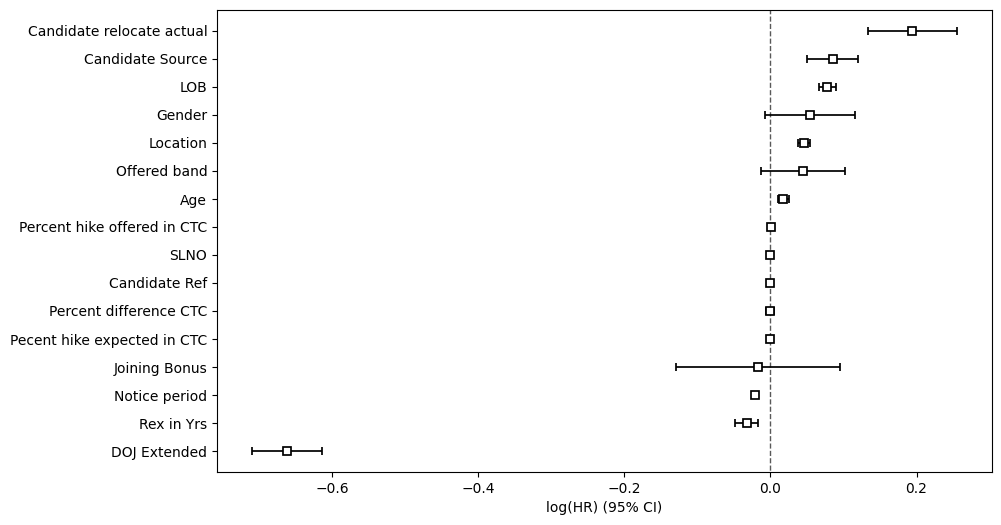

In [32]:
plt.subplots(figsize = (10, 6))
cph.plot()

`DOJ Extended` participe fortement à la non-acceptation de l'offre par le candidat, c'est-à-dire si le candidat doit rentrer à une date non choisie par lui-même il va plus facilement rejeter l'offre. Ce qui paraît logique car si une personne n'a pas le temps de quitter son ancien boulot ou si elle hésite entre plusieurs entreprises, elle a besoin de temps.

Tandis que pour `Candidate relocate actual`, à une valeur positive ce qui implique que si une personne n'a pas besoin de déménager cela favorise l'acceptation de l'offre d'emplois.

Les deux variables sont opposées elles jouent donc un rôle inverse.

On va ensuite faire des analyses plus graphiques, qui peuvent aider à l'interprétation.

### Vérification des hypothèses:

Plot Partial Effects on Outcome (Cox-PH Regression)

<Axes: >

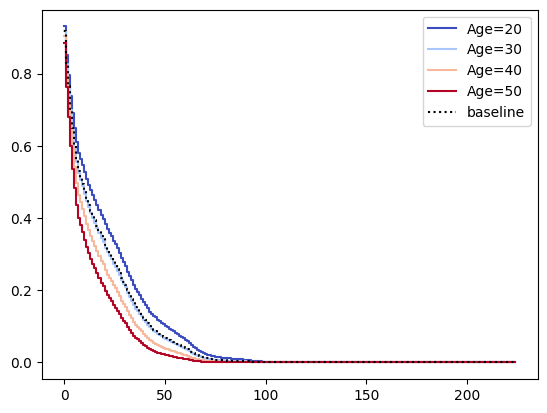

In [33]:
cph.plot_partial_effects_on_outcome(covariates = 'Age', values = [20, 30, 40, 50], cmap = 'coolwarm')

Ici on a regardé l'âge même si elle n'avait pas l'air d'avoir d'importance pour le modèle de cox.

Ce graphique est intéressant car même si elle n'a pas de grande importance pour le modèle de cox, on voit qu'en créent différents groupes en fonction de l'âge, on arrive à avoir une bonne représentation.

Cette représentation nous dit que les personnes plus vielles ont tendance à avoir un risque plus élevé. Dans notre cas cela signifie que les personnes plus âgées vont accepter moins vite les offres, contrairement aux plus jeunes. Ce qui paraît logique car une personne plus jeune n'a pas d'expérience, elle va donc avoir moins de propositions d'emploi.

Attention en regardant l'histogramme des âges on remarque que l'on a très peu de personnes à plus de 40 ans. Cette interprétation n'est pas totalement fausse car on voit bien les groupes se distinguer, mais il faut prendre en compte aussi que les individus ne sont pas bien répartis.

<Axes: >

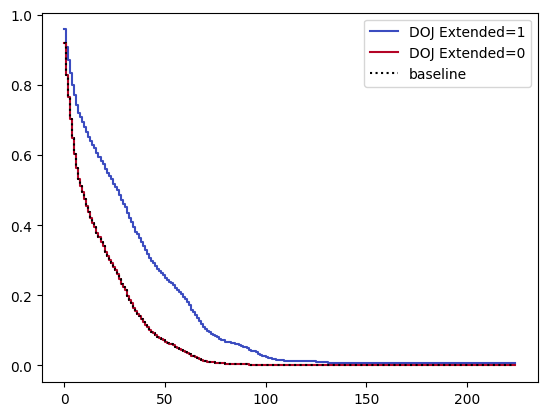

In [34]:
cph.plot_partial_effects_on_outcome(covariates = 'DOJ Extended', values = [1,0], cmap = 'coolwarm')

Ce graphique confirme notre hypothèse sur les personnes qui ne peuvent pas choisir la date d'entrée dans l'entreprise, il y a plus de risques qu'elles ne rejoigne pas l'entreprise.

On va maintenant vérifier deux hypothèses pour chaque covariables:
- l'hypothèse de proportionnalité
- l'hypothèse de concordance

In [35]:
cph.check_assumptions(test, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8995 total observations, 1682 right-censored observations>
         test_name = proportional_hazard_test

---
                                  test_statistic      p  -log2(p)
Age                         km              0.25   0.62      0.70
                            rank            0.49   0.48      1.05
Candidate Ref               km             54.54 <0.005     42.58
                            rank           56.64 <0.005     44.12
Candidate Source            km              8.69 <0.005      8.29
                            rank            9.17 <0.005      8.67
Candidate relocate actual   km              8.29 <0.005      7.97
                            rank            5.14   0.02      5.42
DOJ Extended                km            296.69 <0.005    218.45
                            rank          288.11 <0.005    212.24
Gender                      km              3.41   0.06      3.95
                            rank            3.15   0.08      3.72
Joining Bonus               km              0.00   0.98      0.03
                            rank            0.01   0.93      0.11
LOB                         km             32.60 <0.005     26.40
                            rank           28.12 <0.005     23.06
Location                    km             12.88 <0.005     11.56
                            rank           14.97 <0.005     13.16
Notice period               km             36.31 <0.005     29.15
                            rank           25.62 <0.005     21.20
Offered band                km              1.45   0.23      2.13
                            rank            3.19   0.07      3.75
Pecent hike expected in CTC km              0.65   0.42      1.26
                            rank            0.64   0.42      1.24
Percent difference CTC      km              1.01   0.31      1.67
                            rank            1.00   0.32      1.65
Percent hike offered in CTC km              0.45   0.50      0.99
                            rank            0.45   0.50      1.00
Rex in Yrs                  km              0.44   0.51      0.98
                            rank            0.38   0.54      0.90
SLNO                        km              1.82   0.18      2.50
                            rank            0.00   0.95      0.08



1. Variable 'Candidate Ref' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Candidate Ref' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Candidate Ref' using pd.cut, and then specify it in
`strata=['Candidate Ref', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'DOJ Extended' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['DOJ Extended', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'Notice period' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the

[]

Grace a ces différents tests d'hypothèse, on peut dire que la variable `' DOJ Extendes'` ne valide pas l’hypothèse de proportionnalité. On peut l'interpréter de la manière que si la personne sait qu'elle ne pourra pas rentrer à telle date dans l'entreprise alors elle refuse directement  l'offre elle ne pas réfléchir plus longtemps.

Contrairement à la variable âge qui vérifie ce test, donc n'importe quel âge (ici on n'a pas regardé en fonction de différents groupes) implique une proportionnalité dans le risque

### Résidus de Martingales et de déviance

In [ ]:
r = cph.compute_residuals(test, 'martingale')
r.head()

,Duration to accept offer,Status,martingale
28,0.0,False,-0.075271
201,0.0,False,-0.057720
214,0.0,False,-0.098744
272,0.0,False,-0.151413
304,0.0,False,-0.175010


<Axes: xlabel='Duration to accept offer', ylabel='martingale'>

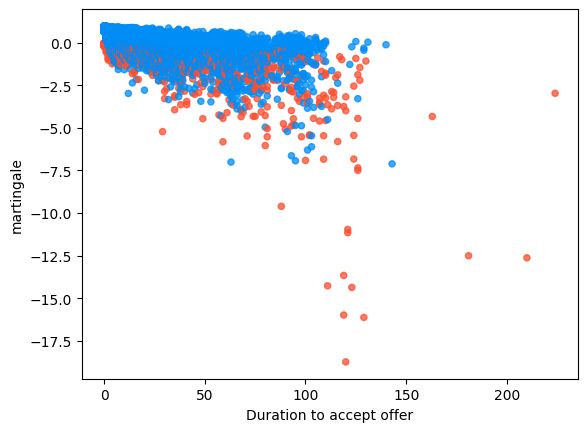

In [ ]:
r.plot.scatter(
    x="Duration to accept offer", y="martingale", c=np.where(r['Status'], '#008df5', '#fc4f30'),
    alpha=0.75
)

In [ ]:
r = cph.compute_residuals(test, 'deviance')
r.head()

,Duration to accept offer,Status,deviance
28,0.0,False,-0.387998
201,0.0,False,-0.339764
214,0.0,False,-0.444397
272,0.0,False,-0.550296
304,0.0,False,-0.591625


In [ ]:
r["Status"].value_counts()

Status
True     7313
False    1682
Name: count, dtype: int64

<Axes: xlabel='Duration to accept offer', ylabel='deviance'>

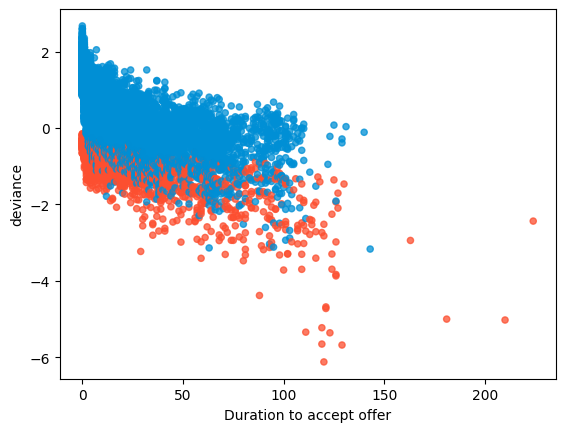

In [ ]:
r.plot.scatter(
    x='Duration to accept offer', y='deviance', c=np.where(r['Status'], '#008fd5', '#fc4f30'),
    alpha=0.75
)

# 2.3. Estiamtion paramètrique <a class="anchor" id="section_2_3"></a>

## 2.3.1. Accelerated Failure Time : `AFT` sans covariables <a class="anchor" id="section_2_3_1"></a>
[Up](#up) 

| Concept | Description |
| ------- | ----------- |
| **AFT (Accélération des Temps de Faille)** | Approche alternative à la modélisation des données de survie en statistique et en analyse de survie. Aussi connue sous le nom de modèle de régression basé sur l'accélération. |
| **Principe de l'AFT** | Accélère ou ralentit le temps jusqu'à un événement en fonction des variables explicatives. Modélise directement la distribution de la durée de survie. |
| **Types de distributions modélisées** | L'AFT permet de modéliser différents types de distributions de survie, notamment la distribution exponentielle (si \(S_0(t)\) est exponentielle) ou la distribution de Weibull (si \(S_0(t)\) est de forme Weibull). |
| **Flexibilité du modèle AFT** | Offre une alternative flexible pour modéliser la distribution des temps de survie en fonction des covariables. |


La forme générale du modèle AFT est donnée par l'équation suivante :

$$ S(t | x) = S_0\left(\left(\frac{t}{\lambda}\right)^{\exp(\beta_1x_1 + \beta_2x_2 + \ldots + \beta_kx_k)}\right) $$

Où :

- $ S(t | x) $ : Fonction de survie conditionnelle à un ensemble de covariables $ x $.
- $ S_0(t) $ : Fonction de survie de base (ou de référence) sans covariables.
- $ \lambda $ : Paramètre d'échelle qui contrôle le temps.
- $ \beta_1, \beta_2, \ldots, \beta_k $ : Coefficients de régression associés aux covariables $ x_1, x_2, \ldots, x_k $.


Nous allons donc chercher a trouver le meilleur estimateur pour `Duration to accept offer`

In [ ]:
df['Duration to accept offer'] = df['Duration to accept offer'].replace(0, 0.01)  # Remplace 0 par 0.01

In [ ]:
from tabulate import tabulate
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, GeneralizedGammaFitter

wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()
gamma = GeneralizedGammaFitter()

results = []
min_aic = float('inf')
min_bic = float('inf')

for model in [wb, ex, log, loglogis, gamma]:
    model.fit(durations=df["Duration to accept offer"], event_observed=df["Status"])
    aic = model.AIC_
    bic = model.BIC_
    results.append([
        model.__class__.__name__,
        aic,
        bic
    ])
    if aic < min_aic:
        min_aic = aic
    if bic < min_bic:
        min_bic = bic

results.sort(key=lambda x: x[1])

headers = ["Model", "AIC", "BIC"]
table = tabulate(results, headers, tablefmt="pretty")

table = table.replace(str(min_aic), f'\033[91m{min_aic}\033[0m')
table = table.replace(str(min_bic), f'\033[91m{min_bic}\033[0m')

print(table)


+------------------------+--------------------+--------------------+
|         Model          |        AIC         |        BIC         |
+------------------------+--------------------+--------------------+
| GeneralizedGammaFitter | 58705.015855681115 | 58726.32912812027  |
|     WeibullFitter      | 59360.83493470748  | 59375.043783000256 |
|   LogLogisticFitter    | 60924.72505560153  |  60938.9339038943  |
|    LogNormalFitter     | 61946.457046655356 | 61960.66589494813  |
|   ExponentialFitter    | 62485.07084340577  | 62492.17526755215  |
+------------------------+--------------------+--------------------+


In [ ]:
from lifelines import GeneralizedGammaFitter

gamma_aft = GeneralizedGammaFitter()
gamma_aft.fit(df["Duration to accept offer"], event_observed=df["Status"])
gamma_aft.print_summary(3)


<lifelines.GeneralizedGammaFitter:"GeneralizedGamma_estimate", fitted with 8995 total observations, 1682 right-censored observations>
   number of observations = 8995
number of events observed = 7313
           log-likelihood = -29349.508
               hypothesis = mu_ != 0, ln_sigma_ != 0, lambda_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
mu_        3.787      0.031            3.726            3.849
ln_sigma_  0.026      0.024           -0.022            0.074
lambda_    2.251      0.071            2.113            2.389

            cmp to       z       p   -log2(p)
mu_          0.000 120.683 <0.0005        inf
ln_sigma_    0.000   1.048   0.295      1.762
lambda_      1.000  17.729 <0.0005    231.221
---
AIC = 58705.016

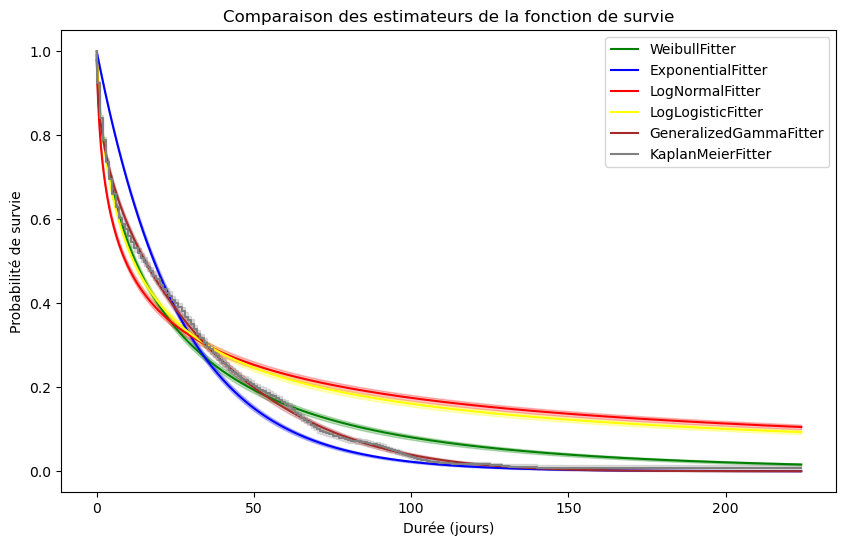

In [ ]:
import matplotlib.pyplot as plt
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, GeneralizedGammaFitter

kmf = KaplanMeierFitter()
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()
gamma = GeneralizedGammaFitter()

plt.figure(figsize=(10, 6))

for model in [wb, ex, log, loglogis, gamma, kmf]:
    model.fit(durations=df["Duration to accept offer"], event_observed=df["Status"])
    model.plot_survival_function(label=model.__class__.__name__)

plt.xlabel('Durée (jours)')
plt.ylabel('Probabilité de survie')
plt.title('Comparaison des estimateurs de la fonction de survie')
plt.legend()

plt.show()

<center>

|                | AIC                                       | BIC                             | formule   |
|----------------|---------------------------------------------------|--------------------------------------------| ---------------------|
| AFT (WeibullFitter )   | 59360 | 59375         | $S(t)= exp(-\frac{t}{λ}\ )^p$ | 
| AFT (ExponentialFitter )   | 62485 | 62492           |  $S(t)= exp(-\frac{t}{λ}\ )$ |
| AFT (LogNormalFitter )   | 61946 | 61960           | $S(t)= 1−Φ(\frac{ln(t)−μ}{σ}\ )$ |
| AFT (LogLogisticFitter )   | 60924 | 60938           | $S(t)= 1−Φ(\frac{1}{1 + (\frac{t}{α}\ )^β }\ )$ |
| `AFT (GeneralizedGammaFitter ) `  | `58705` | `58726`           | $S(t)= 1−G[(\frac{t}{λ}\ )^d  ; a, d, 1 ]$ |
<center>

## 2.3.2. Accelerated Failure Time : `AFT` avec covariables <a class="anchor" id="section_2_3_2"></a>
[Up](#up) 

In [ ]:
import pandas as pd
from lifelines import WeibullAFTFitter, LogLogisticAFTFitter, LogNormalAFTFitter


selected_columns = ['DOJ Extended', 'Offered band', 'Candidate Source', 'Location', 
                    'Notice period', 'Pecent hike expected in CTC',
                    'Percent hike offered in CTC', 'Percent difference CTC', 'Gender',
                    'Rex in Yrs', 'Age', 'Duration to accept offer', 'Status']

df_selected = df[selected_columns]

# Effectuer le one-hot encoding pour les variables catégorielles
df_selected = pd.get_dummies(df_selected, columns=['DOJ Extended', 'Offered band', 'Candidate Source', 'Location'], drop_first=True)

# Inverser la censure dans 'Status'
df_selected['Status'] = 1 - df_selected['Status']

# Ajouter une petite valeur positive aux durées non positives
df_selected['Duration to accept offer'] = df_selected['Duration to accept offer'].where(df_selected['Duration to accept offer'] > 0, 1e-5)

models = [
    WeibullAFTFitter(),
    LogLogisticAFTFitter(),
    LogNormalAFTFitter()
]

# Métriques pour évaluation
metrics = {
    'Model': [],
    'AIC': [],
    'BIC': []
}

# Ajuster et évaluer les modèles
for model in models:
    model.fit(df_selected, duration_col='Duration to accept offer', event_col='Status')
    metrics['Model'].append(model.__class__.__name__)
    metrics['AIC'].append(model.AIC_)
    metrics['BIC'].append(model.BIC_)

# Afficher les résultats
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


                  Model           AIC           BIC
0      WeibullAFTFitter  18741.007897  18709.216745
1  LogLogisticAFTFitter  18824.737945  18792.946794
2    LogNormalAFTFitter  19112.020293  19080.229141


On remarque qu'en présence de covariance, Weibull reste le meilleur modèle d'après les critères d'AIC et BIC.

On va regarder plus particulièrement les variables qui contribuent au modèle :

In [ ]:
import pandas as pd
from lifelines import WeibullAFTFitter

selected_columns = ['DOJ Extended', 'Offered band', 'Candidate Source', 'Location', 
                    'Notice period', 'Pecent hike expected in CTC',
                    'Percent hike offered in CTC', 'Percent difference CTC', 'Gender',
                    'Rex in Yrs', 'Age', 'Duration to accept offer', 'Status']

df_selected = df[selected_columns]
df_selected = pd.get_dummies(df_selected, columns=['DOJ Extended', 'Offered band', 'Candidate Source', 'Location'], drop_first=True)

# Inverser la censure dans 'Status'
df_selected['Status'] = 1 - df_selected['Status']

df_selected['Duration to accept offer'] = df_selected['Duration to accept offer'].where(df_selected['Duration to accept offer'] > 0, 1e-5)

aft = WeibullAFTFitter()

aft.fit(df_selected, duration_col='Duration to accept offer', event_col='Status')

aft.print_summary()


<lifelines.WeibullAFTFitter: fitted with 8995 total observations, 7313 right-censored observations>
             duration col = 'Duration to accept offer'
                event col = 'Status'
   number of observations = 8995
number of events observed = 1682
           log-likelihood = -9345.50
         time fit was run = 2024-01-14 21:56:39 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                  
lambda_ Age                                  0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
        Candidate Source_Direct              0.34       1.41       0.07             0.20             0.48                 1.23                 1.61
        Candidate Source_Employee Referral   0.70       2.02       0.11             0.49             0.91                 1.63                 2.50
        DOJ Extended_Yes                     0.96       2.62       0.07             0.84             1.09                 2.31                 2.98
        Gender                               0.06       1.06       0.09            -0.11             0.23                 0.90                 1.26
        Location_Bangalore                   3.79      44.45       1.28             1.29             6.30                 3.62               546.07
        Location_Chennai                     3.74      41.89       1.28             1.23             6.24                 3.41               514.18
        Location_Cochin                      2.79      16.23       1.81            -0.75             6.33                 0.47               558.81
        Location_Gurgaon                     3.43      30.84       1.30             0.88             5.98                 2.41               394.87
        Location_Hyderabad                   3.59      36.14       1.29             1.06             6.11                 2.90               450.57
        Location_Kolkata                     3.64      38.07       1.30             1.09             6.19                 2.97               487.46
        Location_Mumbai                      3.69      40.09       1.31             1.13             6.25                 3.09               520.24
        Location_Noida                       3.86      47.69       1.28             1.36             6.37                 3.88               586.17
        Location_Others                     11.75   1.27e+05      30.73           -48.49            71.99                 0.00             1.84e+31
        Location_Pune                        3.72      41.33       1.34             1.09             6.35                 2.98               573.16
        Notice period                       -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
        Offered band_E1                      1.38       3.99       0.21             0.98             1.79                 2.66                 5.98
        Offered band_E2                      1.25       3.49       0.23             0.80             1.70                 2.22                 5.49
        Offered band_E3                      1.59       4.90       0.29             1.01             2.17                 2.75                 8.74
        Pecent hike expected in CTC         -0.01       0.99       0.00            -0.02             0.00                 0.98                 1.00
        Percent difference CTC              -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
        Percent hike offered in CTC          0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
        Rex in Yrs                          -0.04       0.96       0.02            -0.08        

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

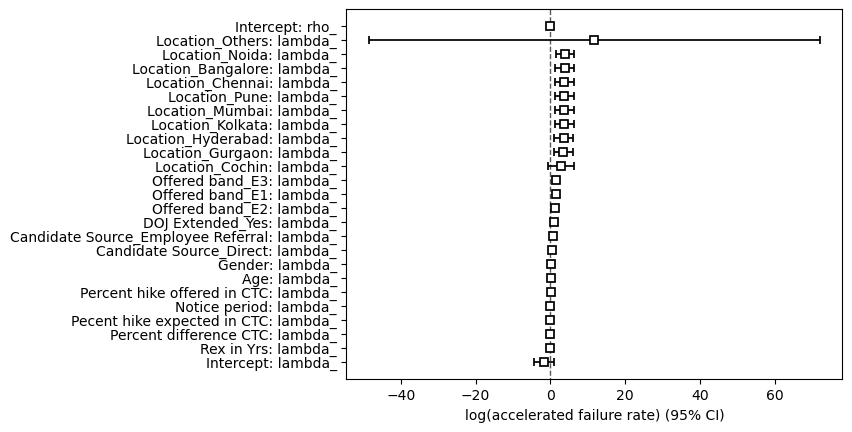

In [ ]:
aft.plot()

Ce graphique nous montre que les variables `'Offered band'` et '`DOJ Extender`' joue un rôle dans le ralentissement d'arrivée de l'événement car ce sont des valeurs positives. Ce qui paraît logique car on l'a déjà vue avec le modèle de cox et aussi pour `'Offered band'` qui est la variable en lien avec le salaire donc il impacte logiquement l'événement

<Axes: >

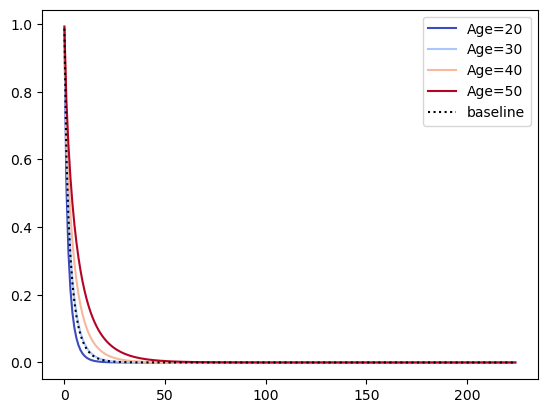

In [ ]:
aft.plot_partial_effects_on_outcome('Age', [20,30,40,50], cmap='coolwarm')

# 2.4. MACHINE LEARNING  <a class="anchor" id="chapter_2_4"></a>
## 2.4.1. Modèles classiques <a class="anchor" id="section_2_4_1"></a>
[Up](#up) 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('Data/hr_data.csv')

X = df.drop('Status', axis=1)  
y = df['Status']

In [ ]:
df["Status"].value_counts()

Status
Joined        7313
Not Joined    1682
Name: count, dtype: int64

In [ ]:
len(df.columns)

18

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((7196, 17), (7196,))

In [ ]:
X_test.shape, y_test.shape

((1799, 17), (1799,))

In [ ]:
cat_cols = ["DOJ Extended", "Offered band", "Joining Bonus", "Candidate relocate actual", "LOB", "Location"]
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
num_cols = [col for col in num_cols if col not in ['SLNO', 'Candidate Ref']]

In [ ]:
len(cat_cols), len(num_cols)

(6, 7)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(), cat_cols) # Encodage des variables catégorielles
    ])

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Duration to accept offer',
                                                   'Notice period',
                                                   'Pecent hike expected in '
                                                   'CTC',
                                                   'Percent hike offered in '
                                                   'CTC',
                                                   'Percent difference CTC',
                                                   'Rex in Yrs', 'Age']),
                                                 ('cat', OneHotEncoder(),
                                                  ['DOJ Extended',
                                                   'Offered band',
                                                   'Joining Bonus',
                                                   'Candidate relocate actual',
                                                   'LOB', 'Location'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8082267926625903


In [ ]:
classifiers = {
    'Random Forest': RandomForestClassifier(),
}

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

for clf_name, clf in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, scoring="accuracy", cv=5)
    grid_search.fit(X_train, y_train)

    print(f"Best hyperparameters for {clf_name}:")
    print(grid_search.best_params_)

    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test)

    precision = accuracy_score(y_test, predictions)
    print(f"Precision for {clf_name}: {precision:.4f}\n")

Best hyperparameters for Random Forest:
{'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Precision for Random Forest: 0.8166



In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(predictions, y_test)

array([[1428,  299],
       [  31,   41]])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC()
}

In [ ]:
for clf_name, clf in classifiers.items():
    # Créer le pipeline avec le préprocesseur et le modèle
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    # Entraîner le modèle
    pipeline.fit(X_train, y_train)

    # Faire des prédictions sur l'ensemble de test
    predictions = pipeline.predict(X_test)

    # Évaluer les performances du modèle
    accuracy = accuracy_score(y_test, predictions)

    # Afficher les métriques
    print(f"{clf_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print("--------")

Decision Tree Metrics:
Accuracy: 0.7298
--------


Random Forest Metrics:
Accuracy: 0.8110
--------
Logistic Regression Metrics:
Accuracy: 0.8116
--------
K-Nearest Neighbors Metrics:
Accuracy: 0.7877
--------


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naive Bayes Metrics:
Accuracy: 0.3357
--------
SVM Metrics:
Accuracy: 0.8110
--------


### Quels sont les variables qui ont le plus d'importance selon le modèle le plus pertinent ?

In [ ]:
# test avec random forest trouver les variables importantes
# pipeline
len(best_model.steps[1][1].feature_importances_)

37

In [ ]:
std = np.std([tree.feature_importances_ for tree in best_model.steps[1][1].estimators_], axis=0)
len(std)

37

In [ ]:
df['DOJ Extended'] # taille 2
len(df['Candidate Source'].unique())  # taille 3 
# gender taille 2
len(df['LOB'].unique()) # taille 9
len(df['Location'].unique()) # taille 11
len(df['Offered band'].unique()) # taille 4
len(df['Joining Bonus'].unique()) # taille 2


2+2+4+11+9+2+3


33

## Commentaire:

Normalement on devrais avoir l'importance pour chaque variable, mais la on en a 39

Du coup je comprend pas pourquoi je me suis dit peut-etre pour variable qualitative il la divise en importance en fonction de chaque valeurs de cette variable

et la ca marche on en a 33 et ensuite les 6 variable quantitative ca fait 39

In [ ]:
len(preprocessor.get_feature_names_out()) # on a bien les 39 variables

37

In [ ]:
importance = best_model.steps[1][1].feature_importances_
labels_RDF = preprocessor.get_feature_names_out()

In [ ]:
feature_importance_df = pd.DataFrame({'Feature': labels_RDF, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,num__Duration to accept offer,0.158244
3,num__Percent hike offered in CTC,0.117600
2,num__Pecent hike expected in CTC,0.113468
4,num__Percent difference CTC,0.108992
1,num__Notice period,0.091847
6,num__Age,0.078434
5,num__Rex in Yrs,0.058714
16,cat__Candidate relocate actual_Yes,0.033796
15,cat__Candidate relocate actual_No,0.031216
24,cat__LOB_INFRA,0.019147


## 2.4.2. SVM scikit-learn Survival <a class="anchor" id="section_2_4_2"></a>
[Up](#up) 

In [ ]:
from sklearn.model_selection import train_test_split
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.svm import FastSurvivalSVM
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('Data/hr_data.csv')

In [ ]:
df['Status'] = np.where(df['Status'] == 'Joined', 1, 0)
df["Duration to accept offer"] = df["Duration to accept offer"] + 0.01

In [ ]:
categorical_columns = ['DOJ Extended', 'Offered band', 'Joining Bonus', 'Candidate relocate actual', 'Gender', 'Candidate Source', 'LOB', 'Location']
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [ ]:
X = df.drop(['Status', 'Duration to accept offer'], axis=1)  # 'Duration to accept offer' est exclu des caractéristiques
y = Surv.from_dataframe('Status', 'Duration to accept offer', df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)


In [ ]:
model = FastSurvivalSVM()
model.fit(X_train_encoded, y_train)

FastSurvivalSVM(optimizer='avltree')

In [ ]:
concordance_index = model.score(X_test_encoded, y_test)
print(f"Concordance Index sur l'ensemble de test : {concordance_index}")

Concordance Index sur l'ensemble de test : 0.5241423751884319


In [ ]:
from sksurv.ensemble import RandomSurvivalForest

# Créez et ajustez le modèle Random Survival Forest
rsf_model = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf_model.fit(X_train_encoded, y_train)

RandomSurvivalForest(random_state=42)

In [ ]:
rsf_concordance_index = rsf_model.score(X_test_encoded, y_test)
print(f"Concordance Index avec Random Survival Forest sur l'ensemble de test : {rsf_concordance_index}")

Concordance Index avec Random Survival Forest sur l'ensemble de test : 0.6912554527830943


In [ ]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

# Créez et ajustez le modèle Gradient Boosting Survival Analysis
gb_model = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=42)
gb_model.fit(X_train_encoded, y_train)

# Évaluez le modèle sur l'ensemble de test
gb_concordance_index = gb_model.score(X_test_encoded, y_test)
print(f"Concordance Index avec Gradient Boosting sur l'ensemble de test : {gb_concordance_index}")


Concordance Index avec Gradient Boosting sur l'ensemble de test : 0.7161142154998391


In [ ]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.model_selection import GridSearchCV

# Utilisez GridSearchCV pour optimiser les hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gb_model = GradientBoostingSurvivalAnalysis(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=3)
grid_search.fit(X_train_encoded, y_train)

# Meilleurs hyperparamètres
best_params = grid_search.best_params_
print(f"Meilleurs hyperparamètres : {best_params}")

# Évaluez le modèle optimisé sur l'ensemble de test
optimized_gb_model = grid_search.best_estimator_
gb_concordance_index = optimized_gb_model.score(X_test_encoded, y_test)
print(f"Concordance Index avec Gradient Boosting sur l'ensemble de test : {gb_concordance_index}")


Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Concordance Index avec Gradient Boosting sur l'ensemble de test : 0.7161142154998391


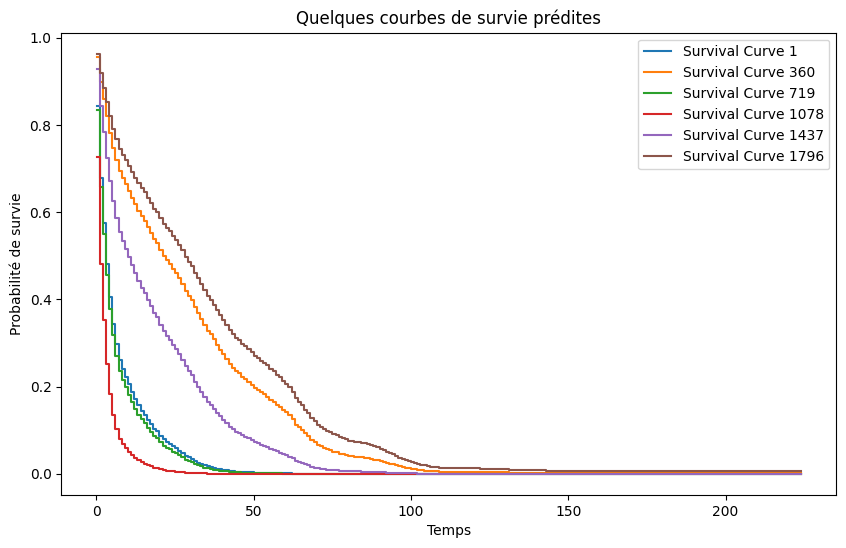

In [ ]:
import matplotlib.pyplot as plt
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

num_curves_to_display = 5  
subset_indices = range(0, len(X_test_encoded), len(X_test_encoded)//num_curves_to_display)

plt.figure(figsize=(10, 6))
for i in subset_indices:
    survival_function = optimized_gb_model.predict_survival_function(X_test_encoded[i:i+1])[0]
    plt.step(survival_function.x, survival_function.y, where="post", label=f"Survival Curve {i + 1}")

plt.xlabel("Temps")
plt.ylabel("Probabilité de survie")
plt.title("Quelques courbes de survie prédites")
plt.legend()
plt.show()


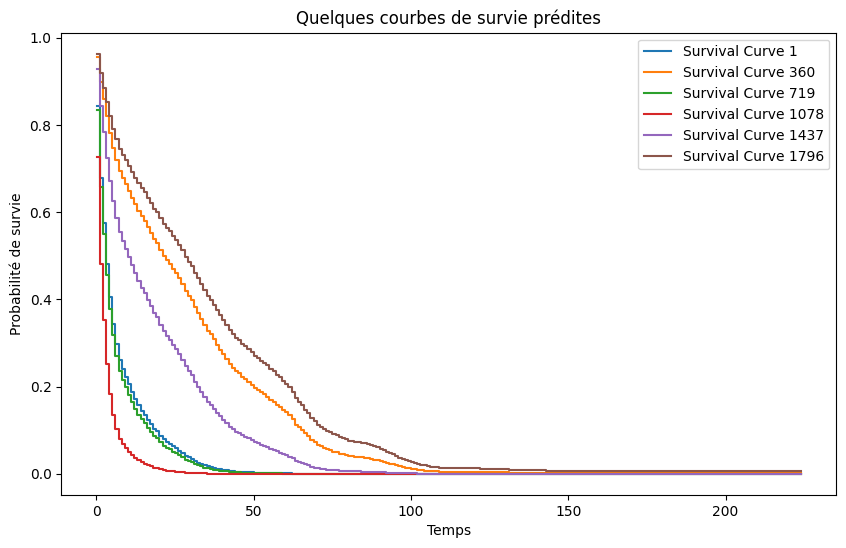

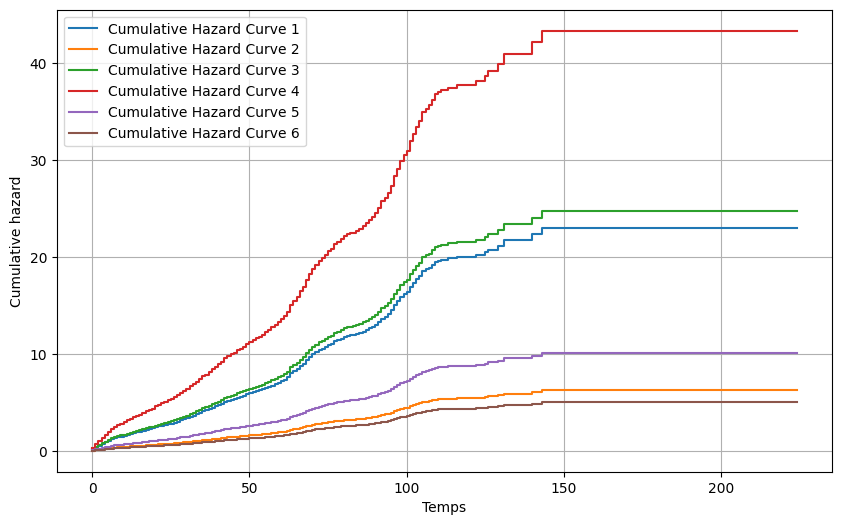

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

# Supposons que optimized_gb_model est votre modèle
# Supposons que X_test_encoded est votre ensemble de test
# Supposons que subset_indices est votre sous-ensemble d'indices

num_curves_to_display = 5
subset_indices = list(range(0, len(X_test_encoded), len(X_test_encoded) // num_curves_to_display))

plt.figure(figsize=(10, 6))
for i in subset_indices:
    survival_function = optimized_gb_model.predict_survival_function(X_test_encoded.iloc[[i]])[0]
    plt.step(survival_function.x, survival_function.y, where="post", label=f"Survival Curve {i + 1}")

plt.xlabel("Temps")
plt.ylabel("Probabilité de survie")
plt.title("Quelques courbes de survie prédites")
plt.legend()
plt.show()

# Prédire les fonctions de survie pour le sous-ensemble de l'ensemble de test
survival_functions_subset = optimized_gb_model.predict_survival_function(X_test_encoded.iloc[subset_indices])

# Calculer les fonctions de risque cumulatif à partir des fonctions de survie
cumulative_hazard_functions_subset = [-np.log(s.y) for s in survival_functions_subset]

# Afficher les courbes de risque cumulatif prédites pour le sous-ensemble
plt.figure(figsize=(10, 6))
for i, chf in enumerate(cumulative_hazard_functions_subset):
    plt.step(survival_functions_subset[i].x, chf, where="post", label=f"Cumulative Hazard Curve {i + 1}")

plt.ylabel("Cumulative hazard")
plt.xlabel("Temps")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(optimized_gb_model, X_test_encoded, y_test, n_repeats=30, random_state=42, n_jobs=-1)


In [ ]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test_encoded.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
Notice period,6.813552e-02,0.004543
DOJ Extended=Yes,6.536305e-02,0.004949
LOB=INFRA,1.861025e-02,0.002284
Candidate Ref,1.310100e-02,0.001909
Rex in Yrs,3.666318e-03,0.001512
Location=Noida,3.496736e-03,0.001182
SLNO,3.444524e-03,0.001086
Percent difference CTC,2.792397e-03,0.000708
Offered band=E1,2.622007e-03,0.001086
LOB=BFSI,1.781255e-03,0.001233


 C'est la moyenne des différences de performances (par exemple, des scores C-index ou d'autres métriques) entre les versions originales du modèle et celles obtenues en permutant aléatoirement les valeurs de chaque variable. Une importance élevée signifie que la variable a un impact significatif sur la performance du modèle. Plus la moyenne est élevée, plus la variable est importante.

# Conclusion

- Après seulement une dizaine de jours, la probabilité d’acceptation de l’offre est de 50%.

- Le facteur de risque est la variable DOJ Extended d’après le modèle de Cox, ce qui signifie que si la date d’entrée en fonction n’est pas respectée par l’employeur, le candidat a de fortes chances de rejeter sa candidature.

- Pour le modèle de Machine Learning, c’est l’augmentation du salaire à l’embauche qui sera déterminant.

- Certaines variables ressortent logiquement comme celles liées au salaire, ce qui va impliquer un changement de risque 

- certaines variables ne vérifiaient pas certaines hypothèses, nous aurions pu appliquer des transformations pour remédier à ce problème mais nous n'avons pas eu le temps

Ce projet a montré que certaines variables méritent d'être approfondies dans l'analyse car elle montre des impacts directs sur le risque du modèle. Il faudrait pouvoir étudier certaines variables entre elles regarder les déséquilibre, les hypothèses ect. Pour pouvoir confirmer tous les résultats